# **Vehicle Detection and Tracking** 
***
In this project, I am applying the tools learned to detect vehciles, using following steps: 
1. Train a Linear SVC classifier, with HOG & color features, to identify a car or not
2. Apply the trained classifier to detect images in frames of a video, and draw bounding boxes


In [1]:
###################################################################################################
## Global settings & imports
###################################################################################################

I_AM_IN_JUPYTER = True
SCRATCH_IMAGE_DIR = 'C:\\Work\\ScratchImages'  # only used when exporting into .py, and setting I_AM_IN_JUPYTER=False
SCRATCH_IMAGE_NUM = 0

TRAIN_SVC = False  # set to false once svc is trained, and it will read cached pickle file

if I_AM_IN_JUPYTER:
    %matplotlib inline
else:
    # use non-interactive back-end to avoid images from popping up
    # See: http://stackoverflow.com/questions/9622163/save-plot-to-image-file-instead-of-displaying-it-using-matplotlib-so-it-can-be
    from matplotlib import use
    use('Agg') 

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from tqdm import tqdm
from sklearn.externals import joblib 
from scipy.ndimage.measurements import label
from collections import deque

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip

# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split

In [2]:
###################################################################################################
## Utility functions for plotting images
###################################################################################################

# function to show a plot or write it to disk, depending if I am running in a jupyter notebook or not
def my_plt_show():
    global I_AM_IN_JUPYTER, SCRATCH_IMAGE_NUM, f_html, f_url
    plt.show()
    if I_AM_IN_JUPYTER == False:
        # at start
        if SCRATCH_IMAGE_NUM == 0:
            # clean out the scratch image dir
            files = glob.glob(SCRATCH_IMAGE_DIR+'\\*')
            for f in files:
                os.remove(f)  
            # open 'all.html' that displays all the images written
            f_html = open(SCRATCH_IMAGE_DIR+'\\all.html', 'w')
            f_url  = 'file:///'+SCRATCH_IMAGE_DIR+'\\all.html'
            f_html.write('<html>\n')
            # webbrowser.open_new(f_url) # open it in new window of default web-browser
            
        # save all images to a scratch dir
        fname = 'img_{:04d}.jpg'.format(SCRATCH_IMAGE_NUM)
        plt.savefig(SCRATCH_IMAGE_DIR+'\\'+fname)
        fig = plt.gcf() # get reference to the current figure
        plt.close(fig)  # and close it
        f_html.write('<img src="'+fname+'" /> <br />\n') 
        f_html.flush() # flush it directly to disk, for debug purposes.    
        # webbrowser.open(f_url, new=0) # refresh the page        
        SCRATCH_IMAGE_NUM += 1
    plt.gcf().clear() # clear the fig

# function to show an image with title
def show_image(image, title, cmap=None ):
    plt.gcf().clear() # clear the fig
    if I_AM_IN_JUPYTER:
        fig, ax = plt.subplots(1, 1, figsize=(24, 10))
    else:
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    plt.title(title)
    if cmap:
        plt.imshow(image, cmap=cmap) # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    else:
        plt.imshow(image)  
    my_plt_show()


In [3]:
###################################################################################################
## Functions for feature generation & extraction
###################################################################################################

# See: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/40ac880a-7ccc-4145-a864-6b0b99ea31e9
# See: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/c3e815c7-1794-4854-8842-5d7b96276642

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)    
    elif conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    elif conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    elif conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    else:
        raise Exception('unsupported color conversion='+conv)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9, 
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in tqdm(imgs):
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orient, pix_per_cell, cell_per_block, 
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features    

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                                     orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [4]:
###################################################################################################
## Train a linear SVM classifier to determine if an image is a car or not
###################################################################################################
pickle_file = 'trained_svc.pickle'
scaler_file = 'scaler.pickle'

# Tweak these parameters and see how the results change.
##color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
##hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
##orient = 8         # HOG orientations
##pix_per_cell = 8    # HOG pixels per cell
##cell_per_block = 2  # HOG cells per block
##spatial_size = (16, 16) # Spatial binning dimensions
##hist_bins = 16      # Number of histogram bins
##spatial_feat = True # Spatial features on or off
##hist_feat = True    # Histogram features on or off
##hog_feat = True     # HOG features on or off

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
orient = 9         # HOG orientations
pix_per_cell = 8    # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32      # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True    # Histogram features on or off
hog_feat = True     # HOG features on or off

if TRAIN_SVC:
    # Read in cars and notcars
    cars    = glob.glob('labeled_data/vehicles/*/*.png')
    notcars = glob.glob('labeled_data/non-vehicles/*/*.png')
    
    # Reduce the sample size for testing...
    #sample_size = 500
    #sample_size = 2000
    
    # Reduce the sample size to avoid memory issues..
    sample_size = 35000
    
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]     
       
    car_features = extract_features(cars, color_space=color_space, 
                                    spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    notcar_features = extract_features(notcars, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    print('Using:',orient,'orientations',pix_per_cell,
          'pixels per cell and', cell_per_block,'cells per block')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    
    # Debug: test call to predict
    y = svc.predict(X_test[0])
    
    # save the trained classifier and corresponding scaler to disk for reuse below
    # see: http://scikit-learn.org/stable/modules/model_persistence.html
    try:
        joblib.dump(svc, pickle_file) 
        joblib.dump(X_scaler, scaler_file)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
        
    print('Cached trained classifier  in pickle file: '+pickle_file)

# read pickled trained classifier from disk
print('Reading classifier & scaler from pickle files: '+pickle_file+', '+scaler_file)
svc = joblib.load(pickle_file)
X_scaler = joblib.load(scaler_file)


Reading classifier & scaler from pickle files: trained_svc.pickle, scaler.pickle


In [5]:
###################################################################################################
## Function that extracts features, makes predictions and draws bounding boxes around cars
###################################################################################################
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
             file=None):
    global heatmap_g 
    
    draw_image = np.copy(img)
    
    bbox_list = [] # to store bounding boxes found in this image
    
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)  
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    # ctrans_tosearch = convert_color(img_tosearch, conv='RGB2HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    #cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    
    # store these new hot_windows for heatmap thresholding
    hotWindows.store(bbox_list)
    
    if show_all:
        tmp_image = draw_boxes(np.copy(draw_image), bbox_list, color=(0, 0, 255), thick=6)
        show_image(tmp_image, title=set_title(frame,file)+' - with Hot Windows' )    
    
    final_image = apply_heatmap_threshold(draw_image, frame, file)
    
    return final_image    


In [6]:
###################################################################################################
## Functions for drawing bounding boxes around the detected cars
###################################################################################################

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


In [7]:
###################################################################################################
## Functions to use heatmaps to find false positives  
###################################################################################################
def apply_heatmap_threshold(image, frame, file):
    # See: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/de41bff0-ad52-493f-8ef4-5506a279b812
    # use heatmap to filter out false positives 
    global hotWindows
    
    heatmap_0 = np.zeros_like(image[:,:,0]).astype(np.float) #  heatmap for this image
    heatmap_1 = np.zeros_like(image[:,:,0]).astype(np.float) #  heatmap for stored images
    heatmap_2 = np.zeros_like(image[:,:,0]).astype(np.float) #  heatmap for stored images
    heatmap_3 = np.zeros_like(image[:,:,0]).astype(np.float) #  heatmap for stored images
    heatmap_c = np.zeros_like(image[:,:,0]).astype(np.float) #  final heatmap
 
    for i in range(len(hotWindows.hot_windows)):
        hot_windows = hotWindows.hot_windows[i]
        if i == 0:
            heatmap_0 = add_heat(heatmap_0, hot_windows)
        elif i == 1:
            heatmap_1 = add_heat(heatmap_1, hot_windows)
        elif i == 2:
            heatmap_2 = add_heat(heatmap_2, hot_windows)
        elif i == 3:
            heatmap_3 = add_heat(heatmap_3, hot_windows)            
        else:
            raise Exception('Too many heatmaps !')

    # combined heatmap
    heatmap_c[(heatmap_0>HEAT_THRESHOLD) & 
              (heatmap_1>HEAT_THRESHOLD) & 
              (heatmap_2>HEAT_THRESHOLD) &
              (heatmap_3>HEAT_THRESHOLD)] = 1
    
    if show_all:
        show_image(heatmap_0, title=set_title(frame, file)+' - Heatmap for this image', cmap='gray' )            
        show_image(heatmap_1, title=set_title(frame, file)+' - Heatmap_1', cmap='gray' )    
        show_image(heatmap_2, title=set_title(frame, file)+' - Heatmap_2', cmap='gray' )    
        show_image(heatmap_c, title=set_title(frame, file)+' - Combined heatmap', cmap='gray' )    
        
    labels  = label(heatmap_c)
    if show_all:
        show_image(labels[0], title=set_title(frame, file)+' - Boxes after heatmap threshold', cmap='gray' )    
    if verbose:
        print(labels[1], 'cars found')
    
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    if show_all:
        show_image(draw_img, title=set_title(frame, file)+' - Boxes after heatmap threshold' )  
        
    return draw_img

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap < threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the labeled box in green on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# class to store hot windows of previous images
class HotWindows():  
    def __init__(self):
        self.hot_windows    = deque([],N_HOT_WINDOWS)
        
    # function to store hot_windows storage
    def store(self, hot_windows):
        # insert last one first. At other end will be pushed out.
        self.hot_windows.appendleft(hot_windows) 


In [8]:
###################################################################################################
## Function to process an image --> returns an image with drawn bounding boxes 
###################################################################################################
def set_title(frame,file):
    if file is None:
        title = 'Frame: '+str(frame)  # when we process videos
    else:
        title = 'File: '+str(file)    # when we process individual files
    return title 
        
def process_image(image, file=None):
    # See: https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/fd66c083-4ccb-4fe3-bda1-c29db76f50a0/concepts/40ac880a-7ccc-4145-a864-6b0b99ea31e9
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # Returns the final output (image with lanes drawn on)
    global frame
    global show_all   
    global verbose    
    global show_final 
    global hotWindows
    
    frame += 1
    
    #if show_all: 
    #    show_image(image, title=set_title(frame,file)+' - Original Image' )
    
    # distortion correct the image
    ## TODO 
    ##image = undistort(image)
    ##if show_all: show_image(image, 'Distortion Corrected Image')
    
    draw_image = np.copy(image)

    ystart = 350
    ystop  = 656
    scale  = 1.5
        
    final_image = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,
                           file=file)
    
    if show_all or show_final:
        show_image(final_image, title=set_title(frame,file) )    
    
    return final_image


In [9]:
###################################################################################################
## Use the trained classifier to detect cars in test video and draw bounding boxes
###################################################################################################

x_start_stop = [None, None]  # Min and max in x to search in slide_window()
y_start_stop = [ 350,  695]  # Min and max in y to search in slide_window()

HEAT_THRESHOLD = 1
N_HOT_WINDOWS  = 4     # number of images for which we save hot_windows, for heatmap filtering

hotWindows = HotWindows()

frame            = 0

# for debugging only:
show_all         = False
show_final       = False
verbose          = False
files_debug_true = None

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

project_video_output = 'videoProject.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!



In [10]:
%time project_video_clip.write_videofile(project_video_output, audio=False)

[MoviePy] >>>> Building video videoProject.mp4
[MoviePy] Writing video videoProject.mp4


100%|█████████▉| 1260/1261 [16:09<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videoProject.mp4 

Wall time: 16min 10s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output))

# Next cell is for debugging the logic

The next cell allows to debug the logic used. The videos were unpacked into individual jpeg files, and the code below allows to read in a certain frame and ask for a lot of intermediate images that demonstrate the car detection process with thresholding.

Testing the lane finding using process_image function


  0%|          | 0/10 [00:00<?, ?it/s]

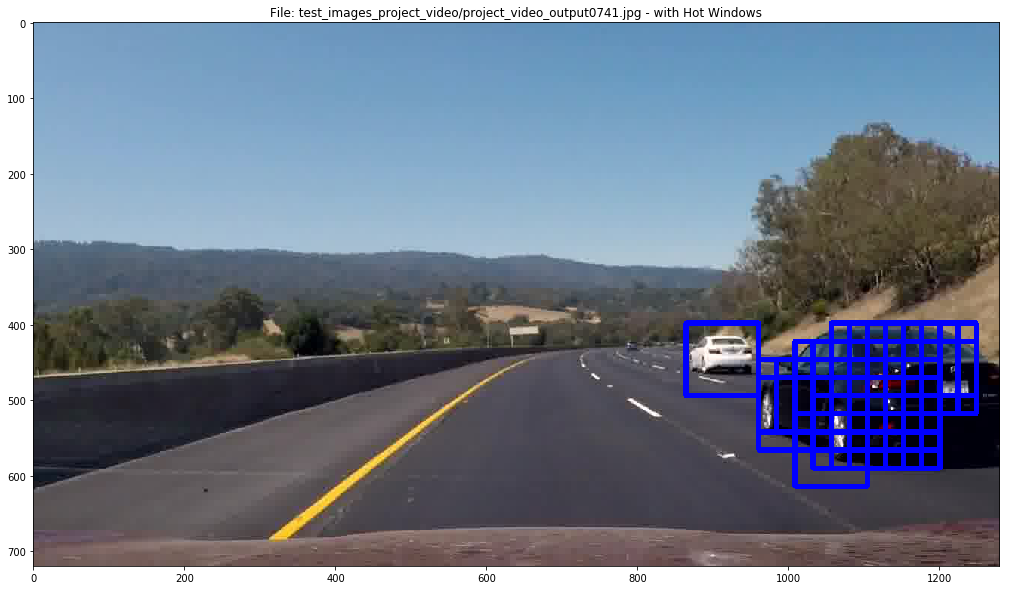

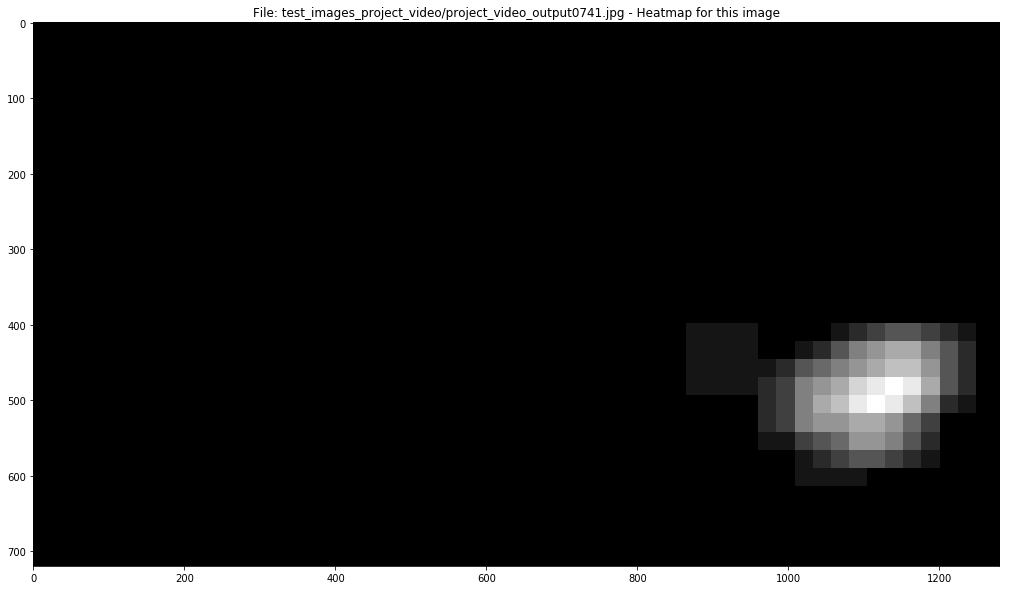

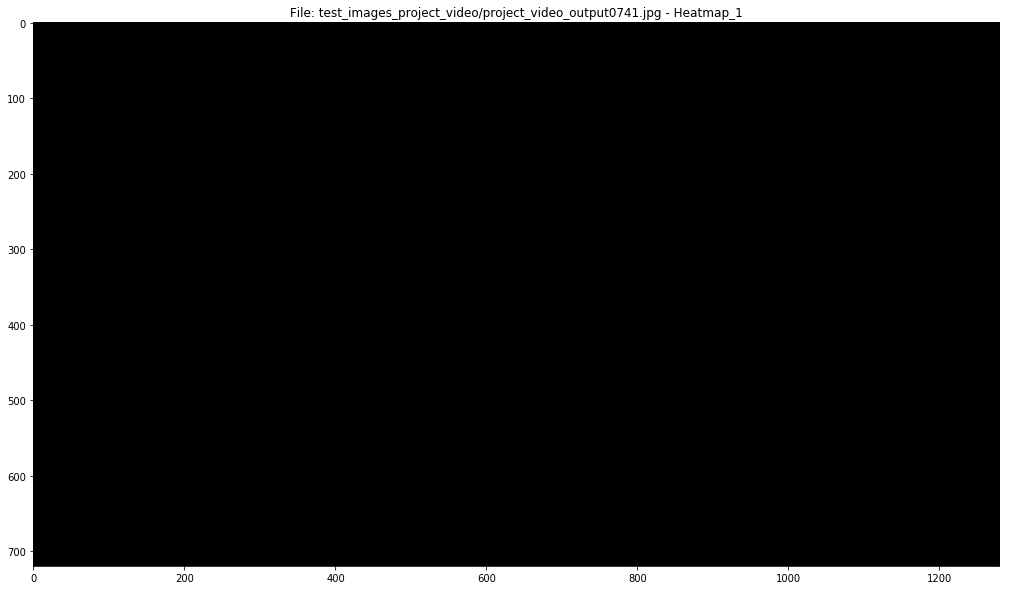

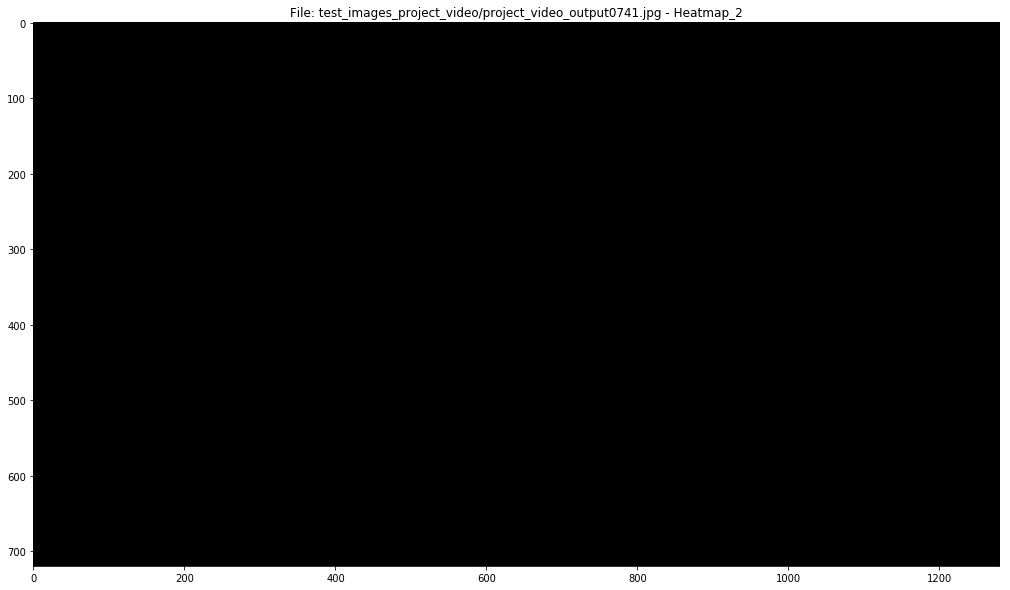

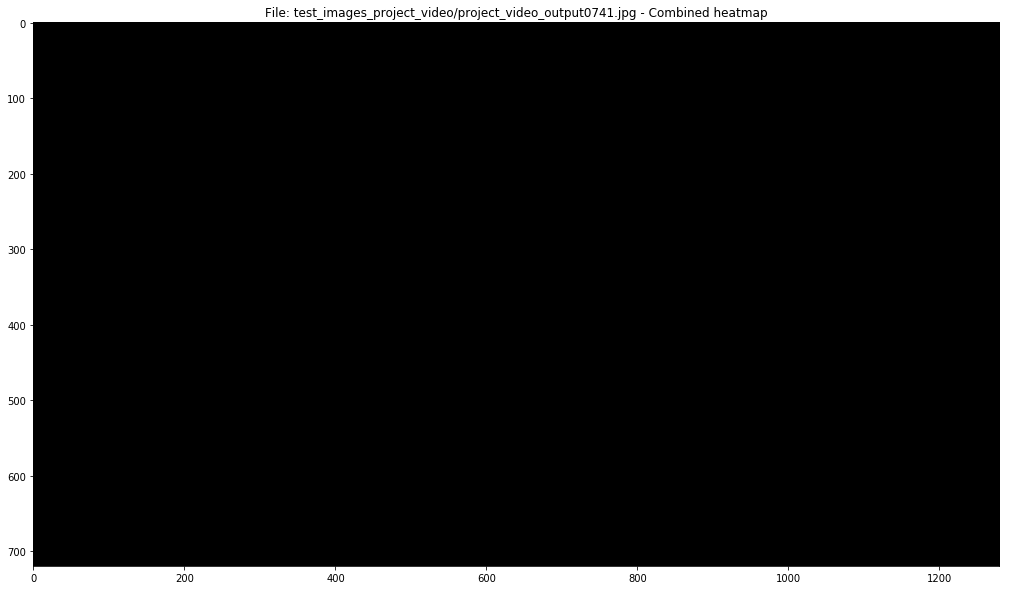

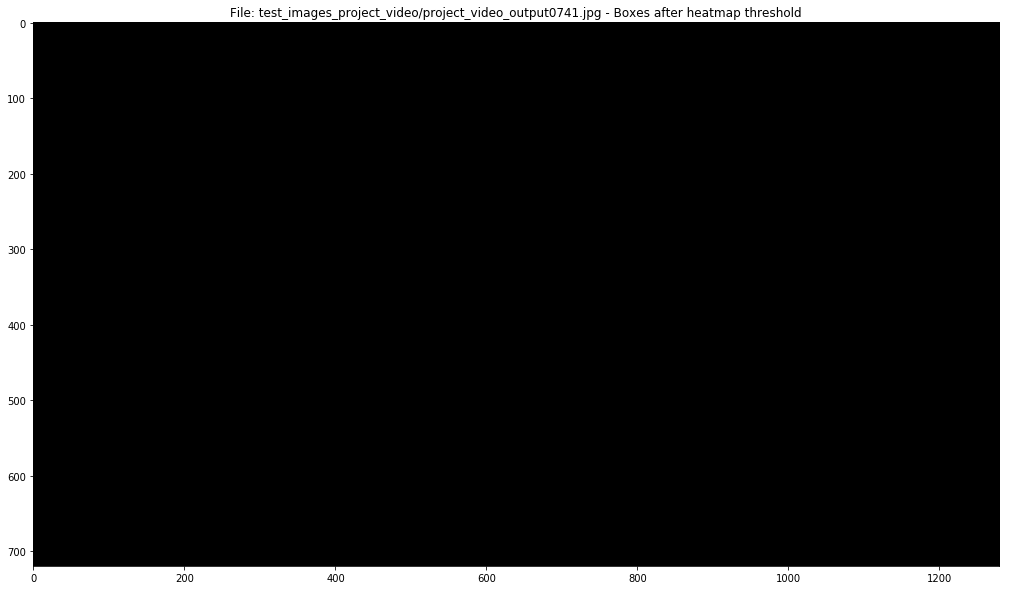

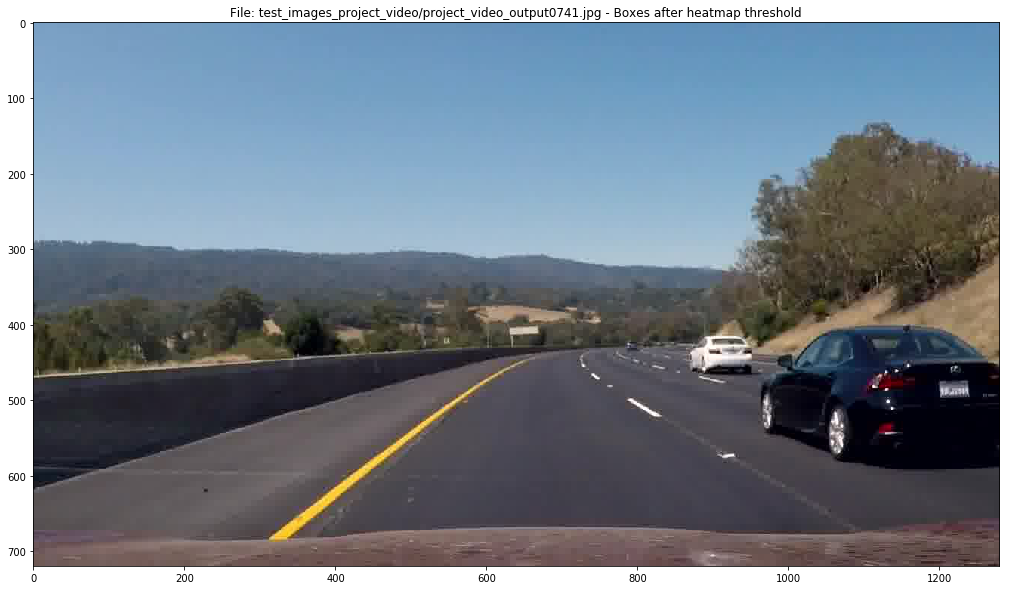

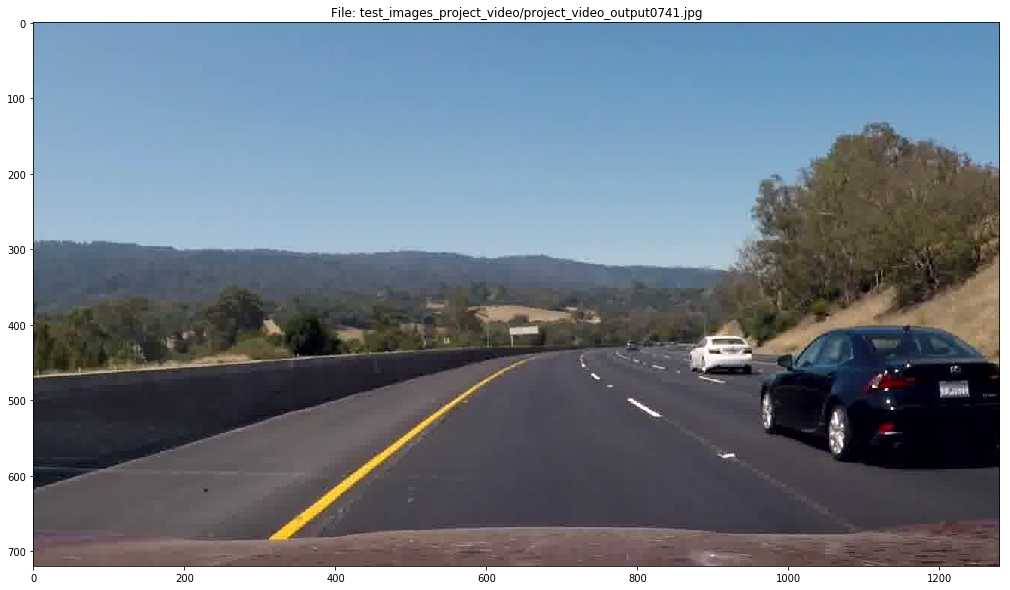

 10%|█         | 1/10 [00:04<00:40,  4.46s/it]

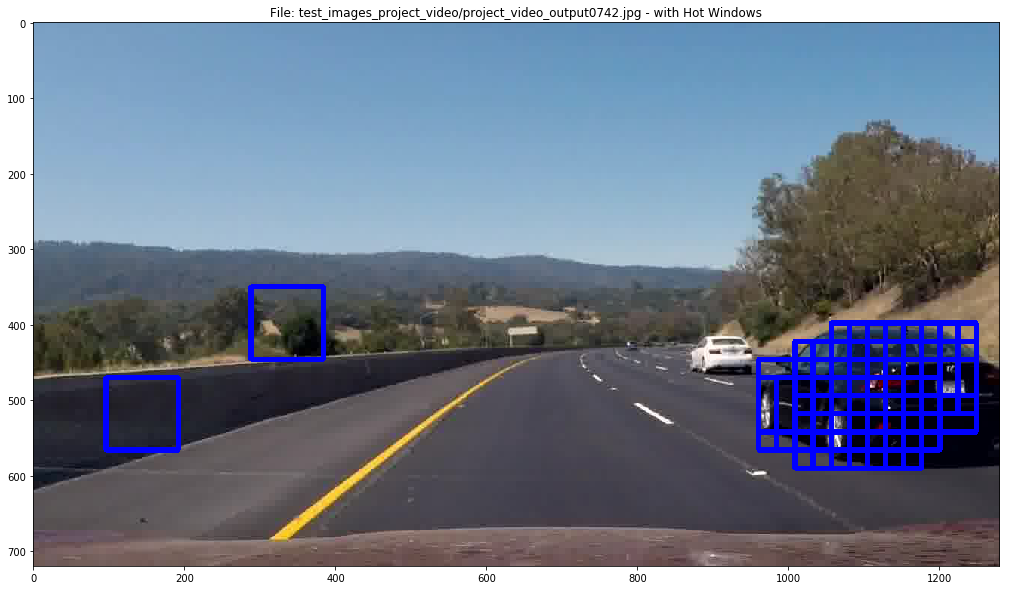

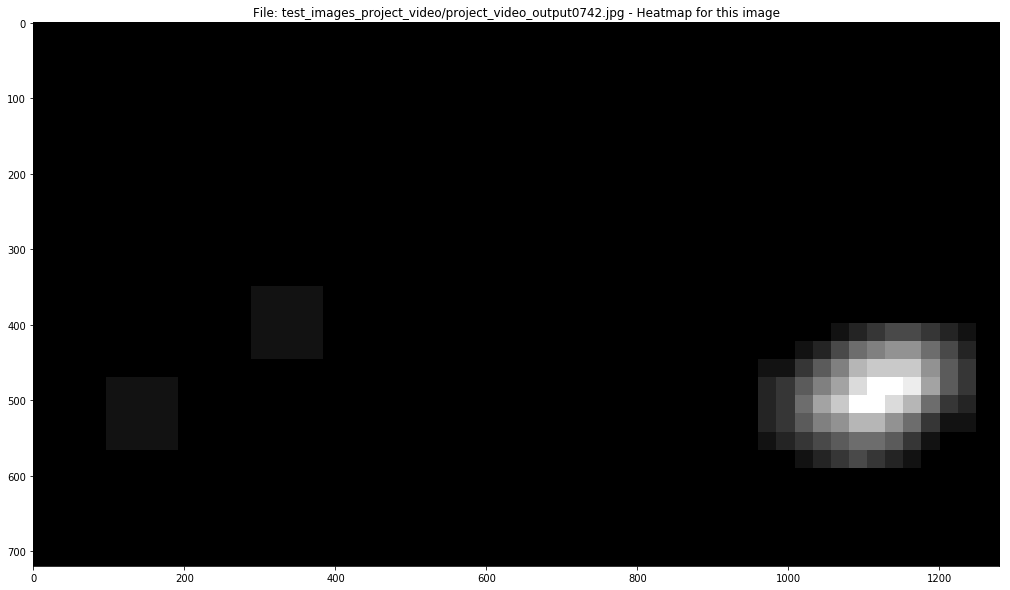

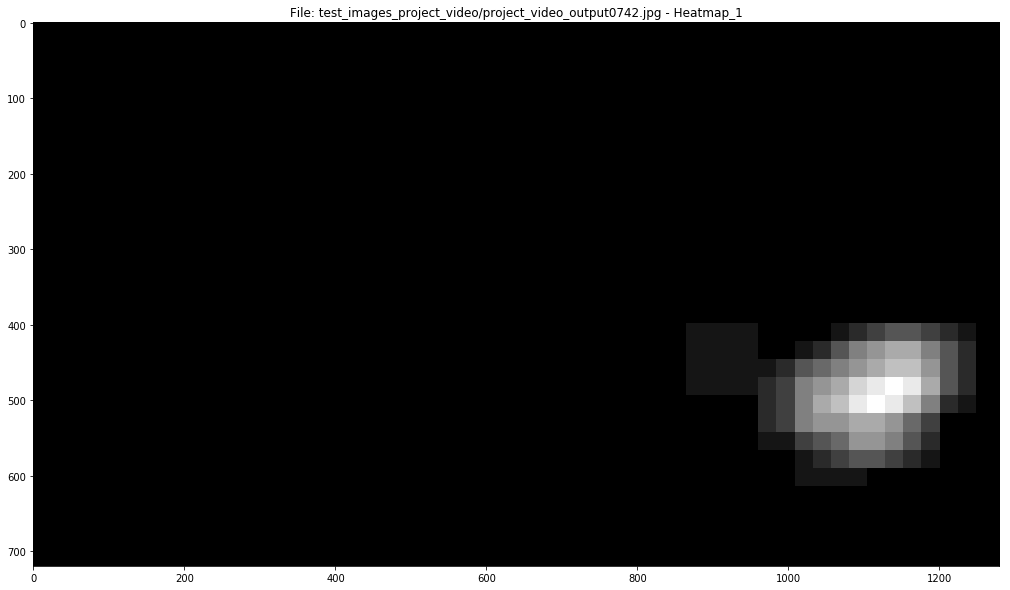

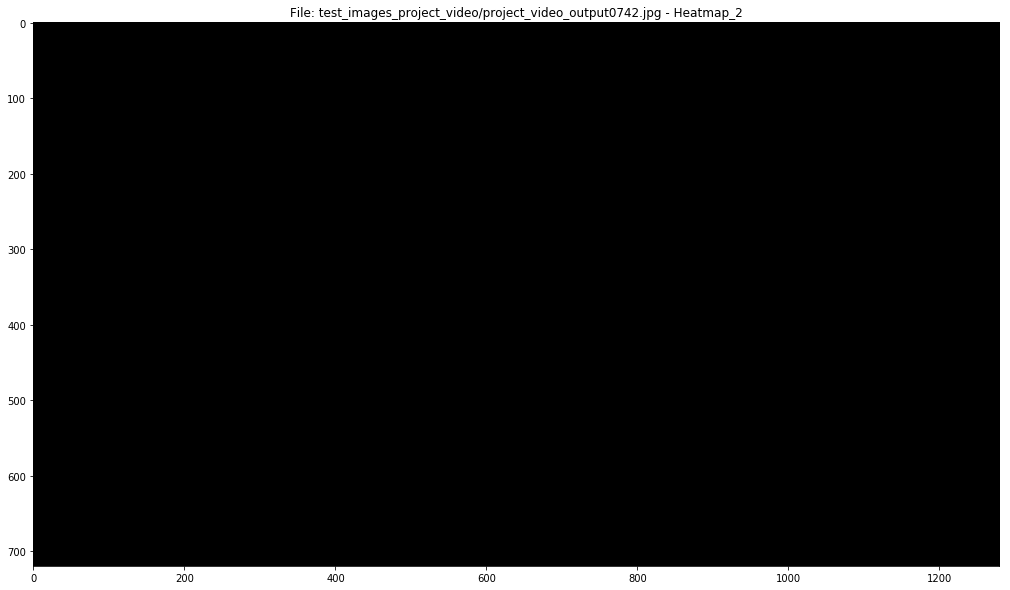

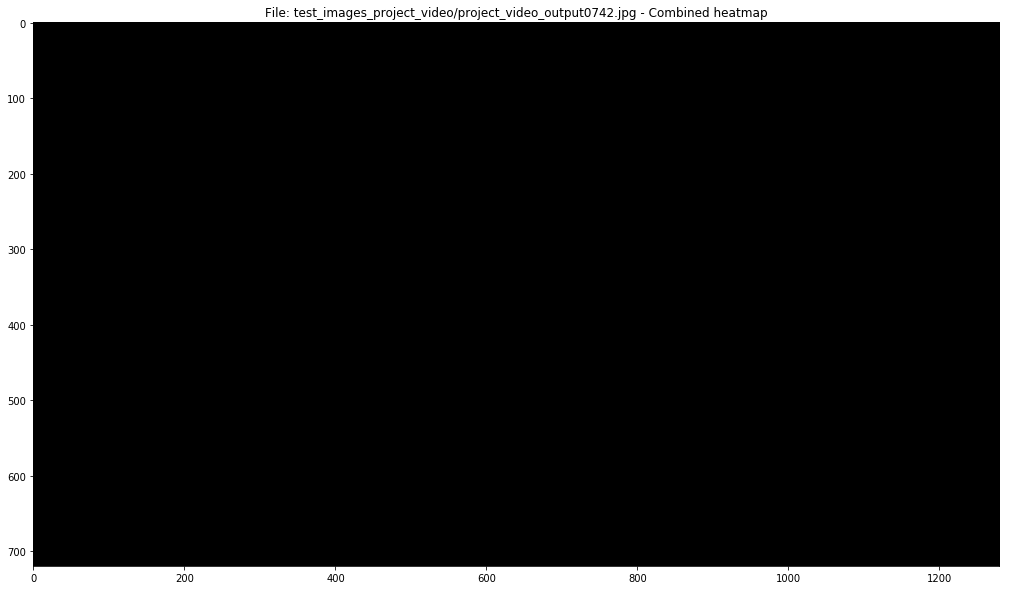

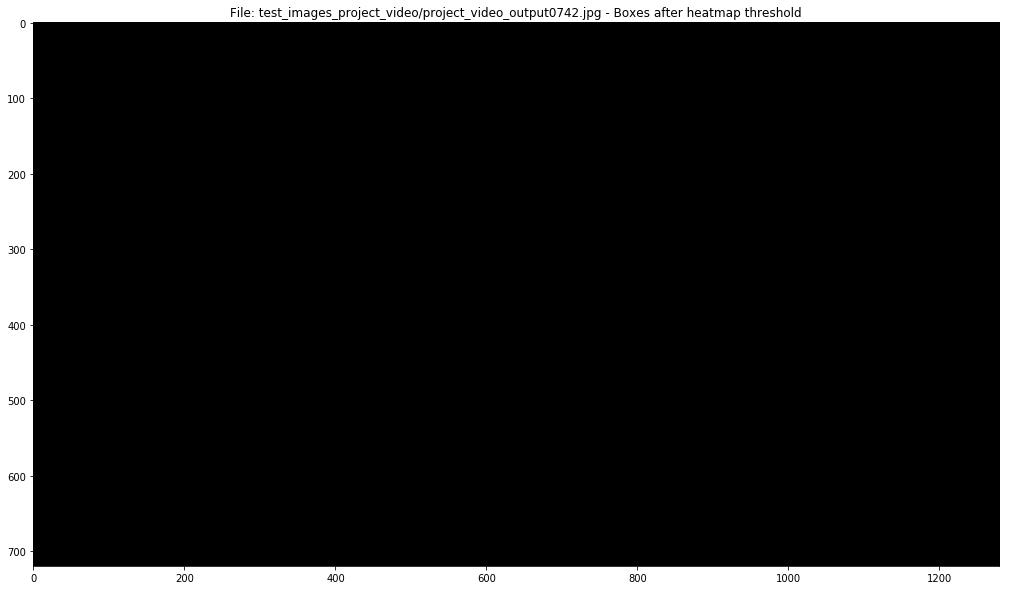

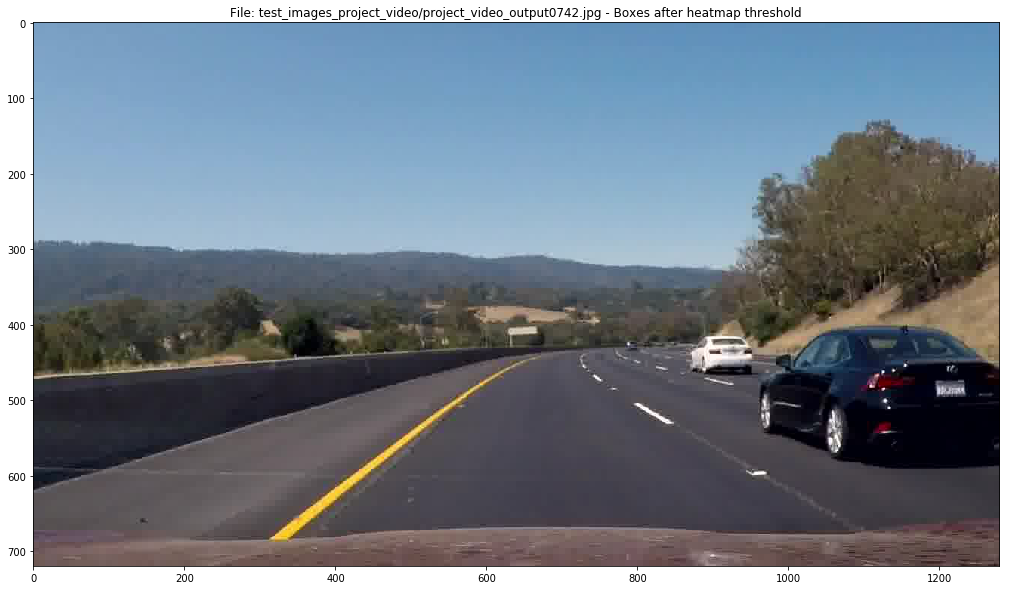

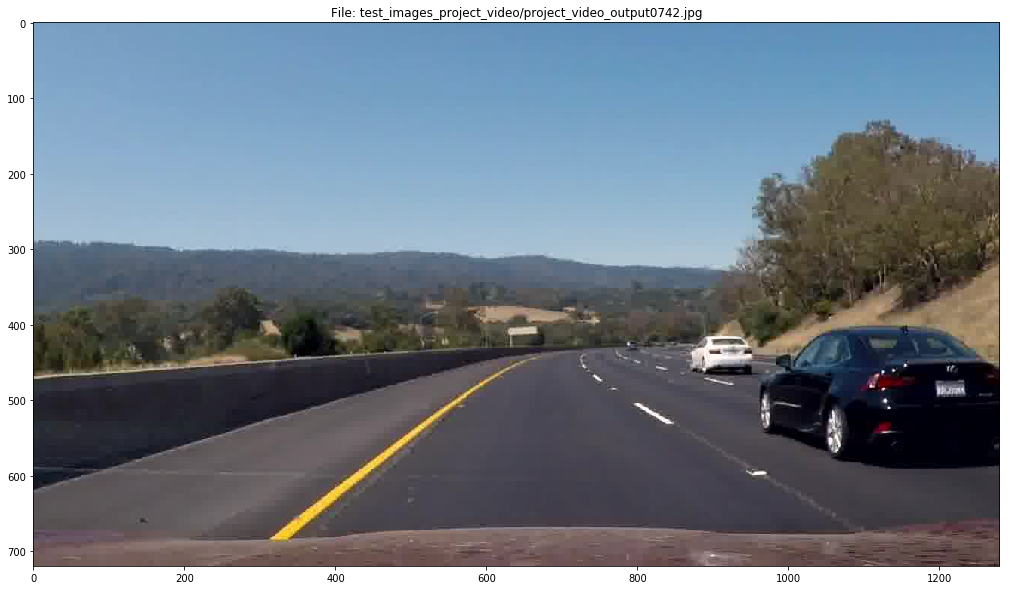

 20%|██        | 2/10 [00:08<00:34,  4.28s/it]

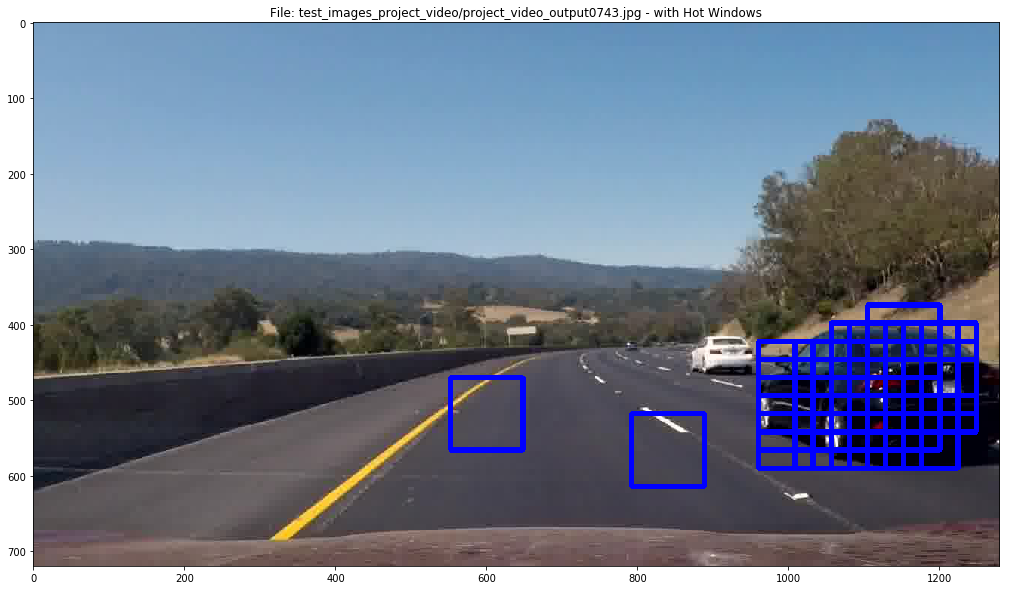

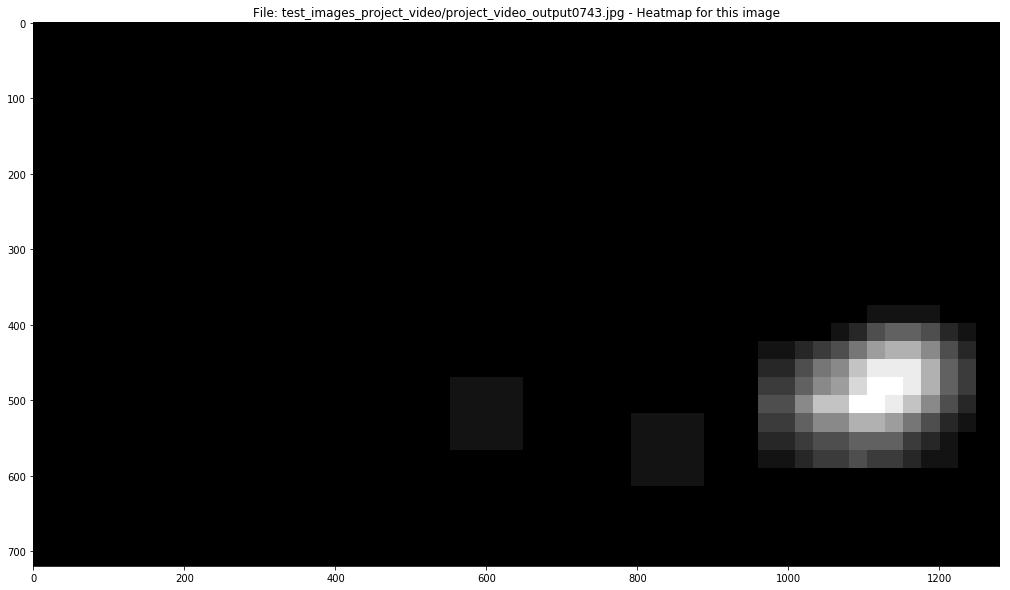

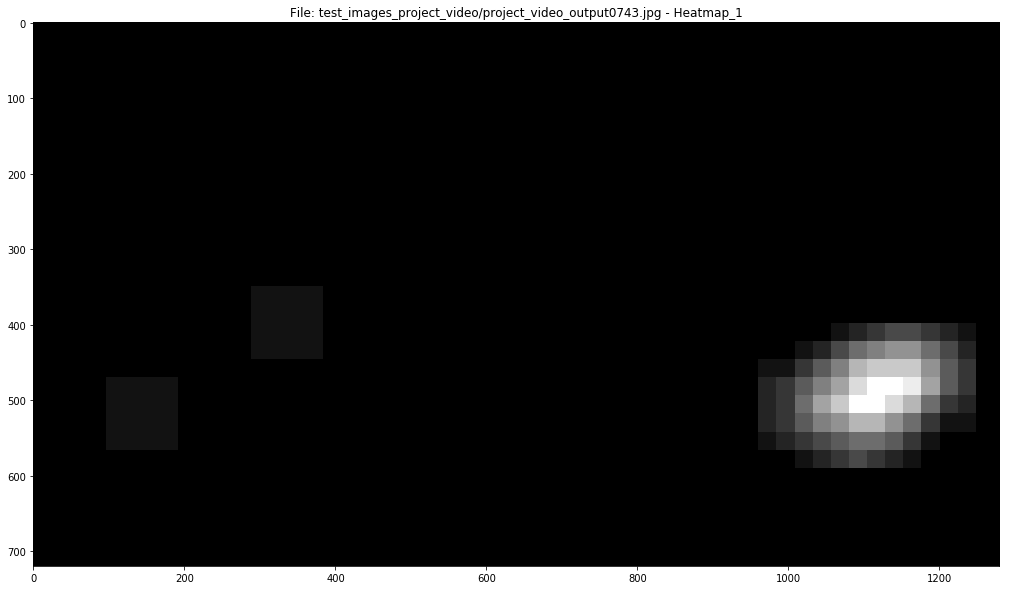

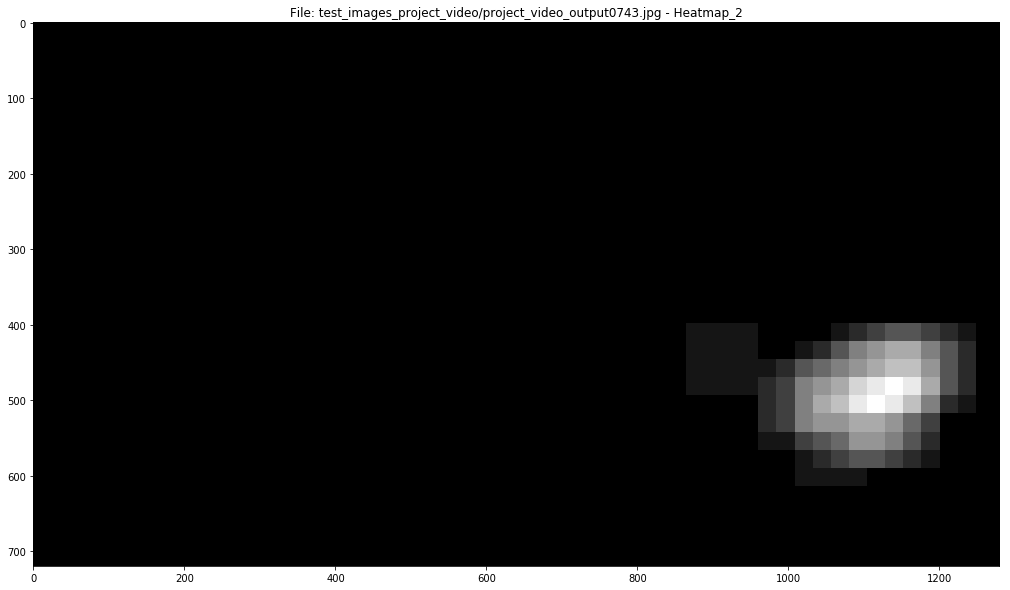

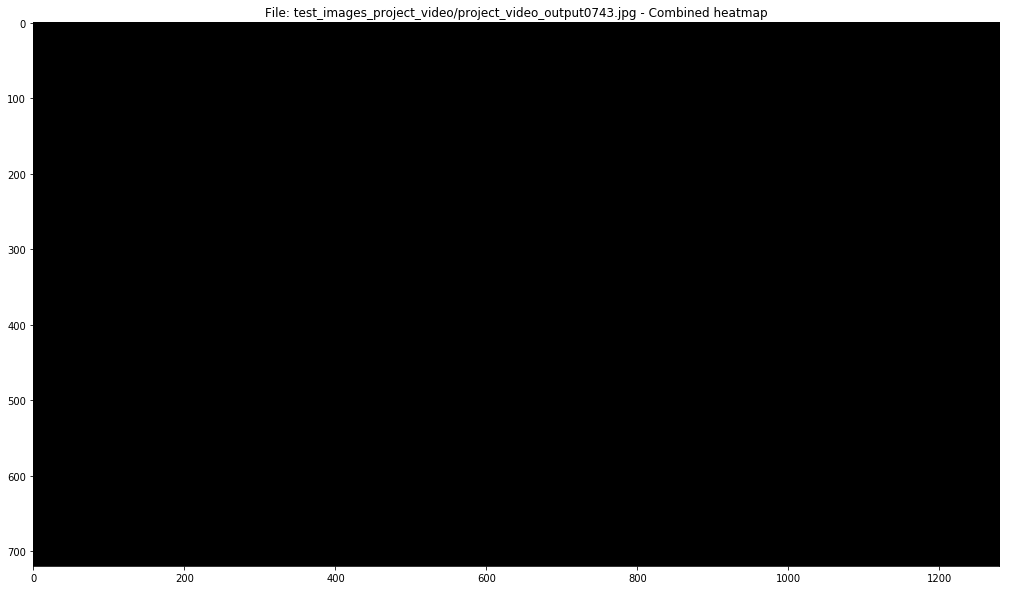

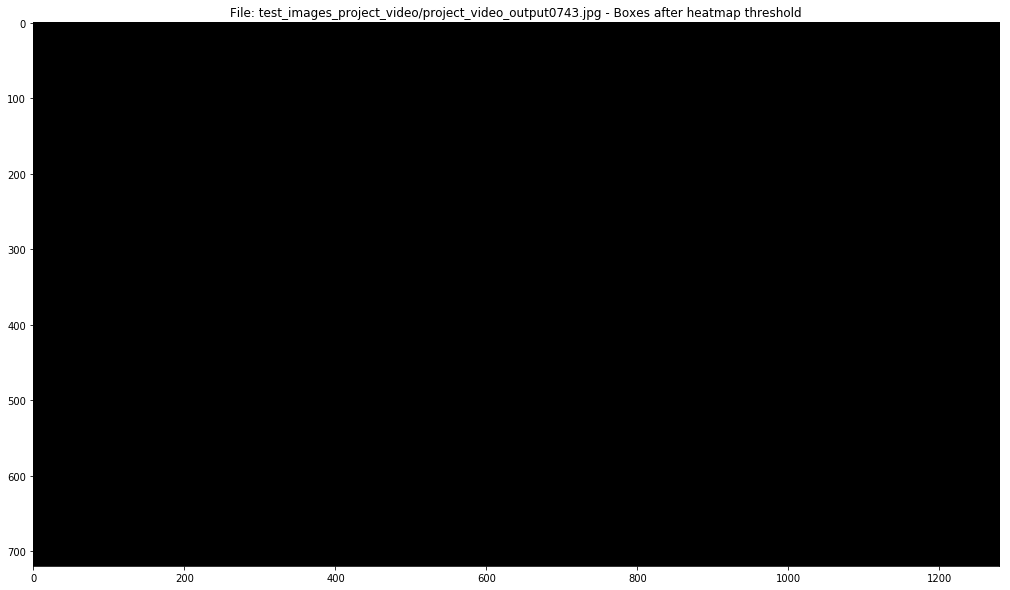

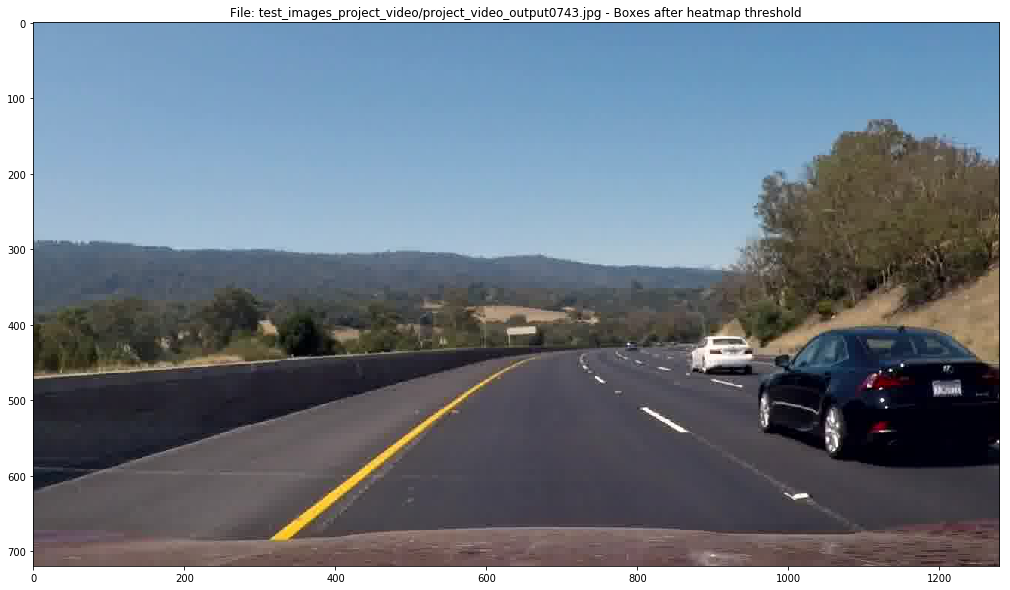

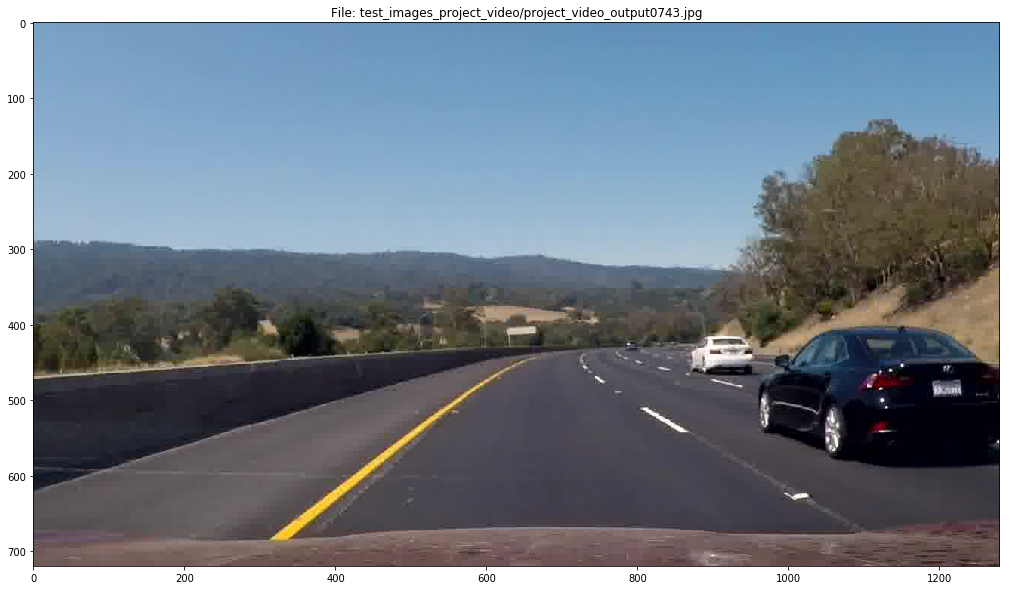

 30%|███       | 3/10 [00:12<00:28,  4.13s/it]

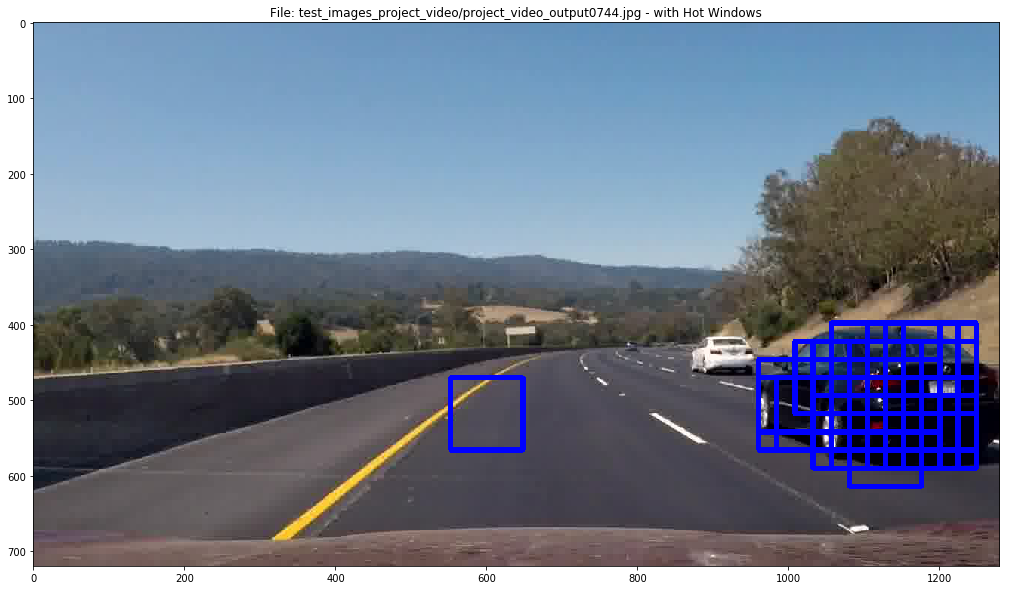

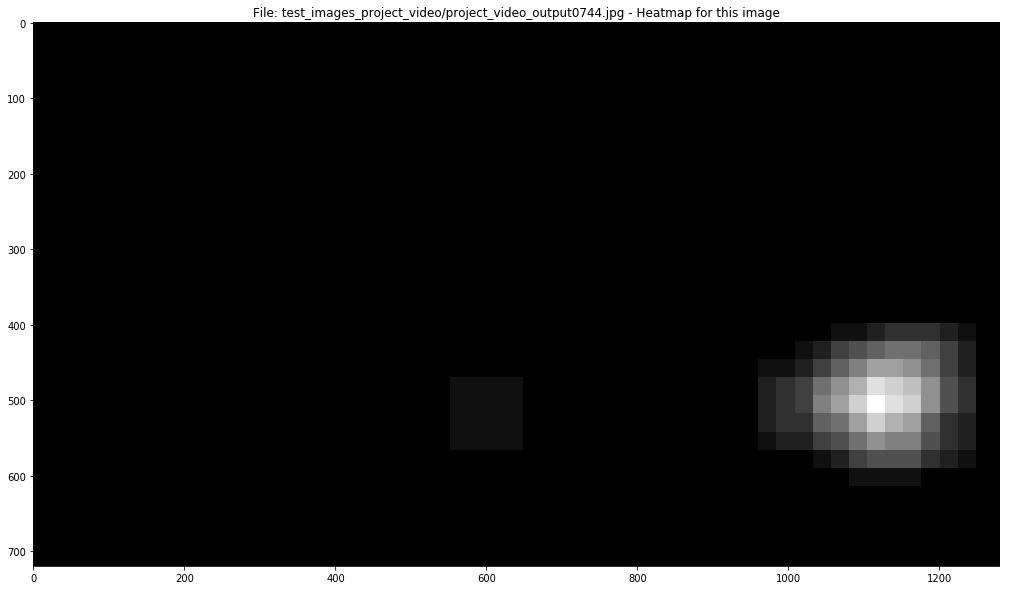

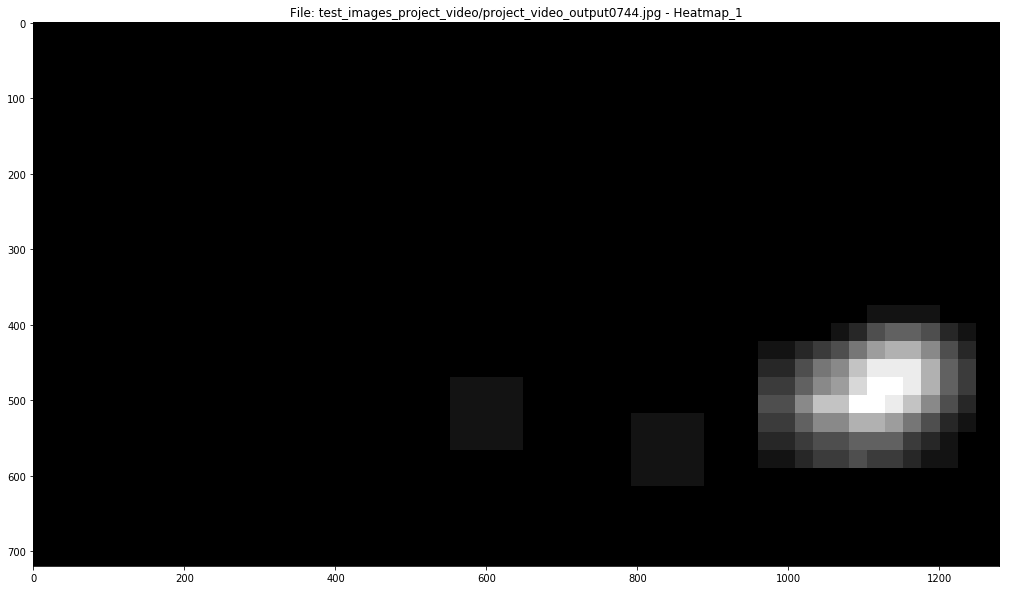

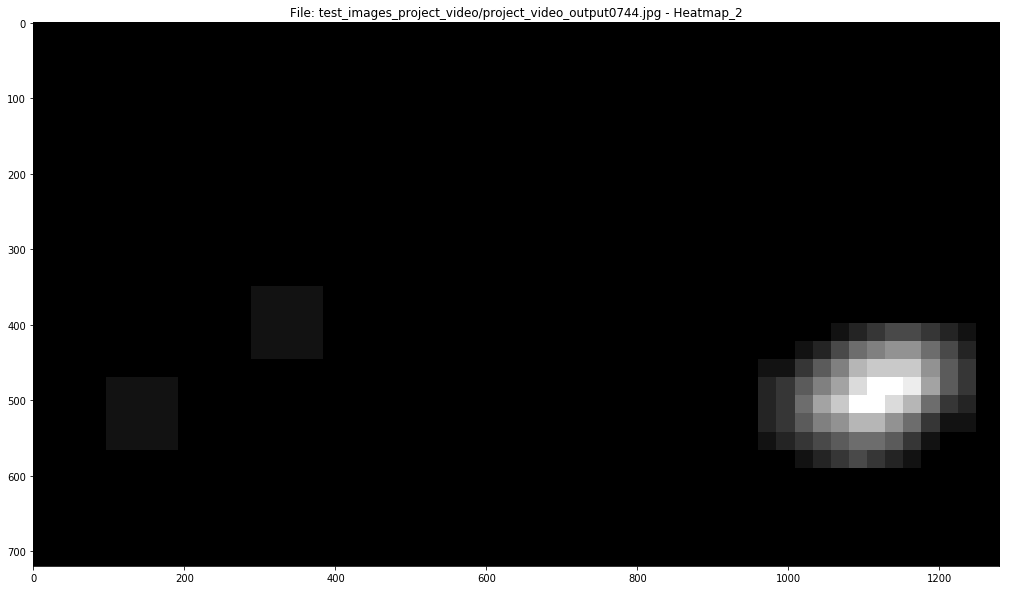

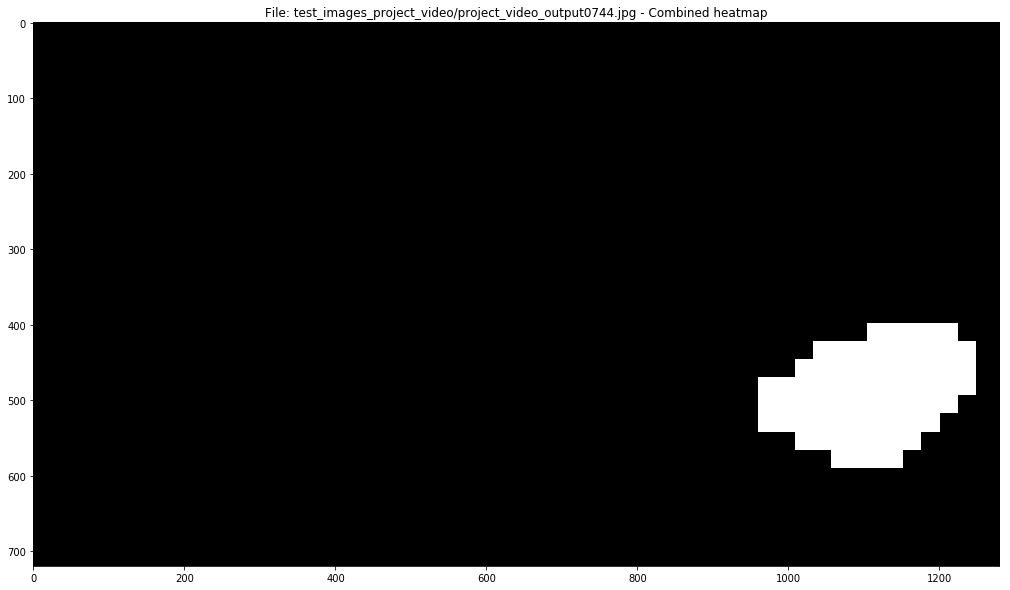

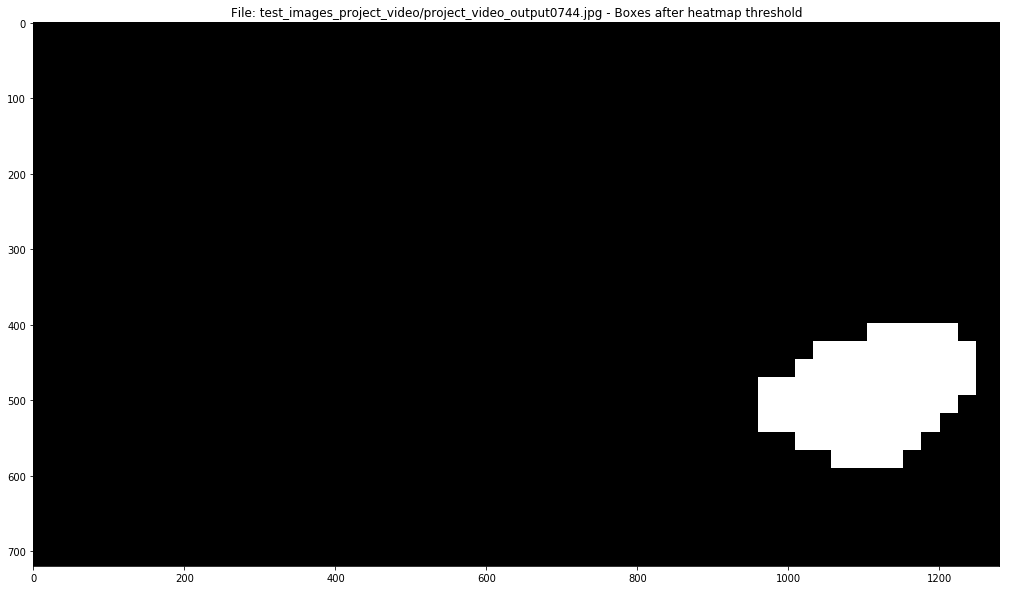

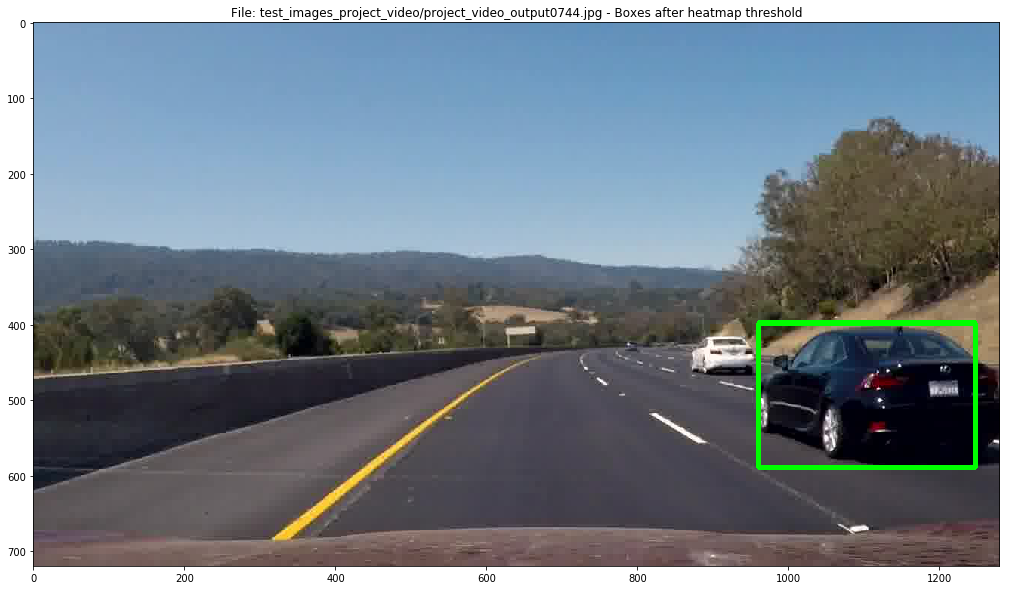

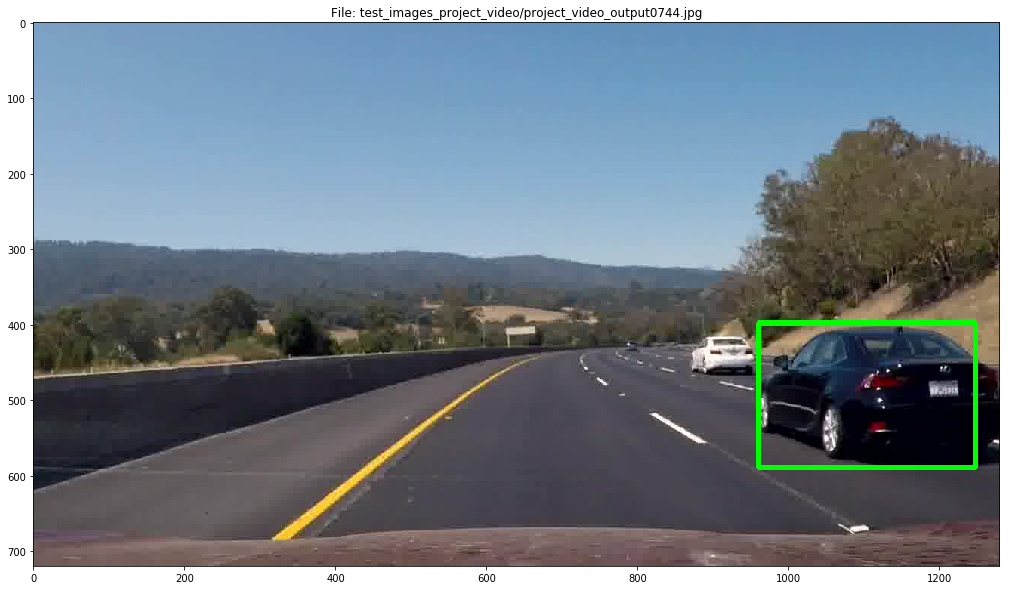

 40%|████      | 4/10 [00:15<00:24,  4.03s/it]

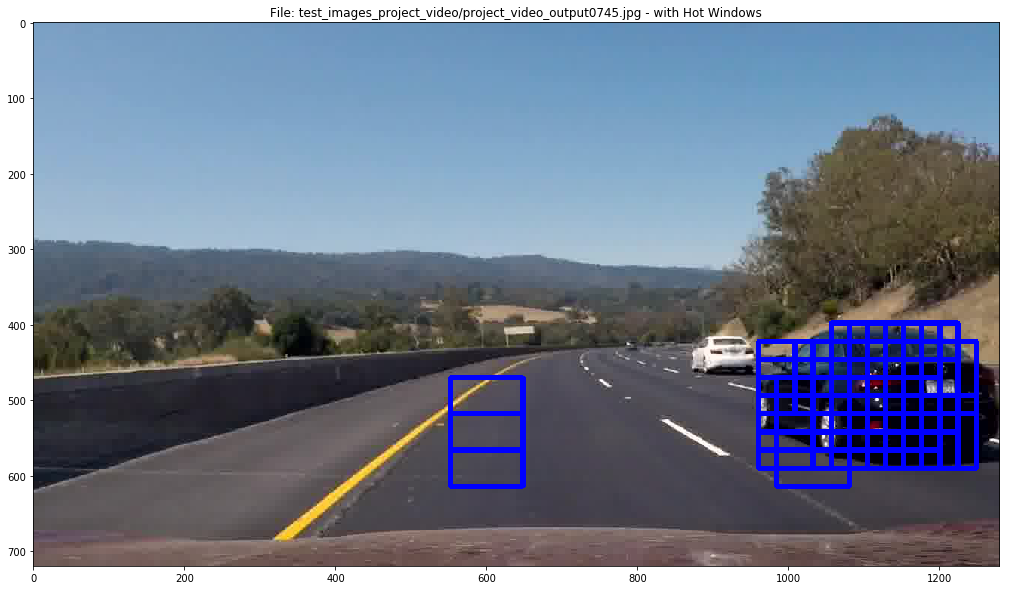

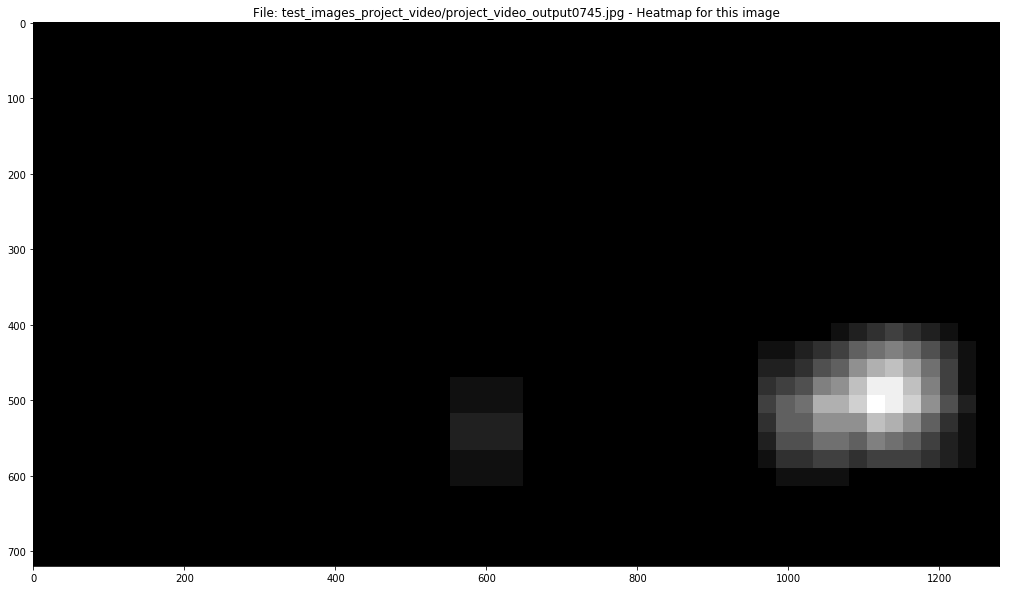

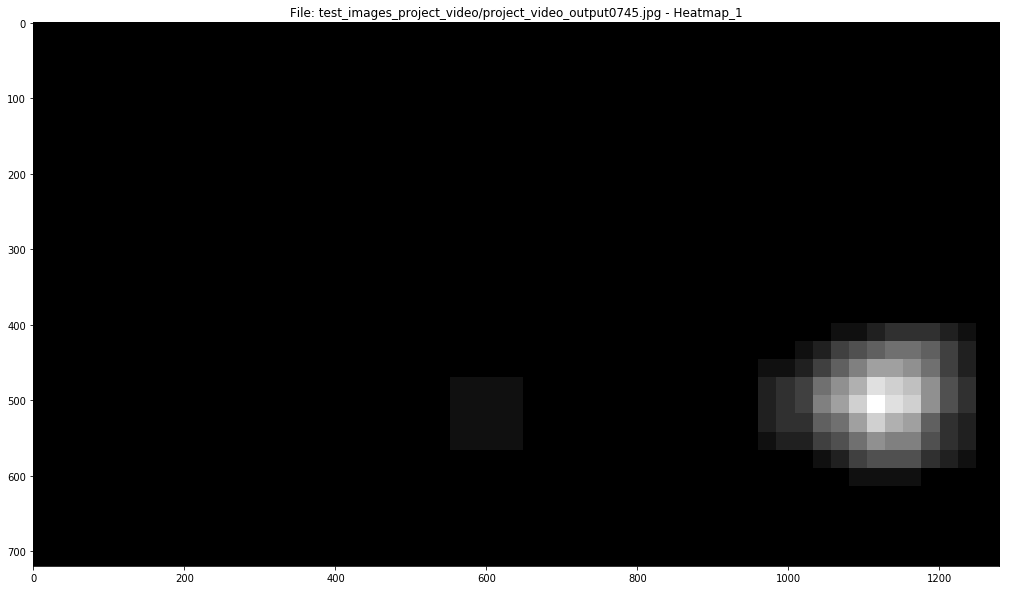

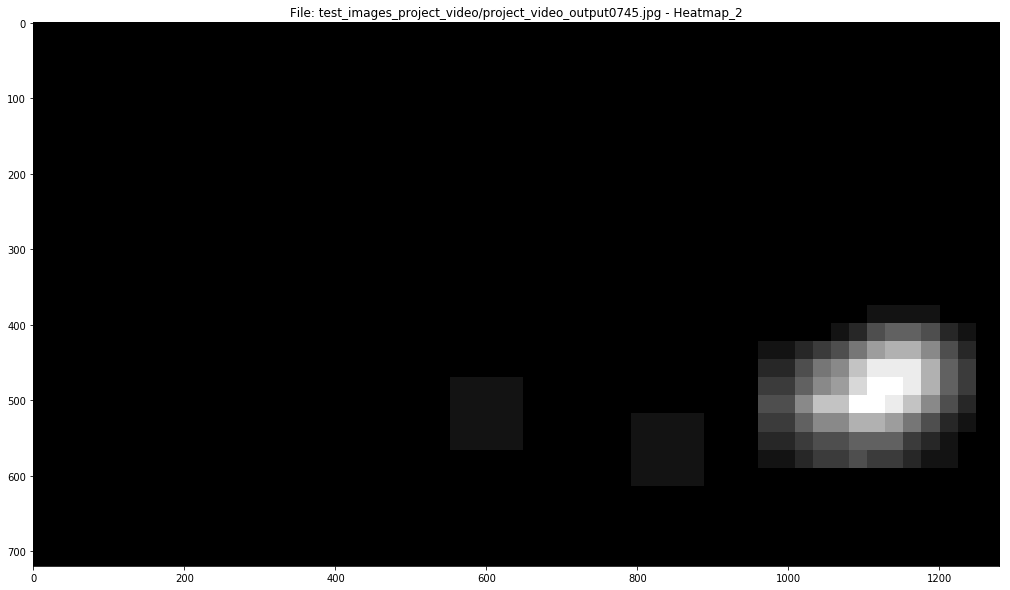

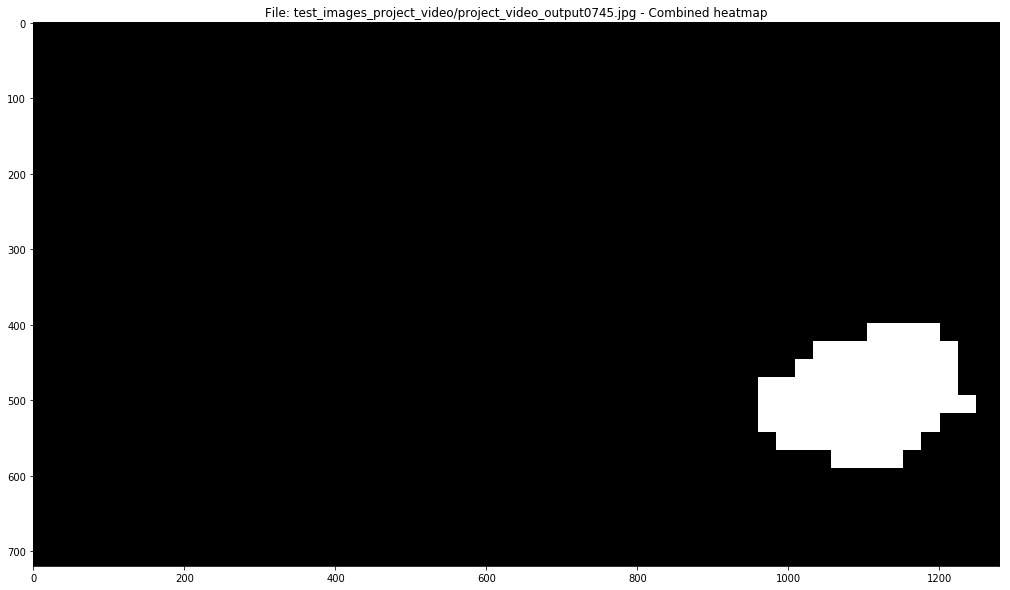

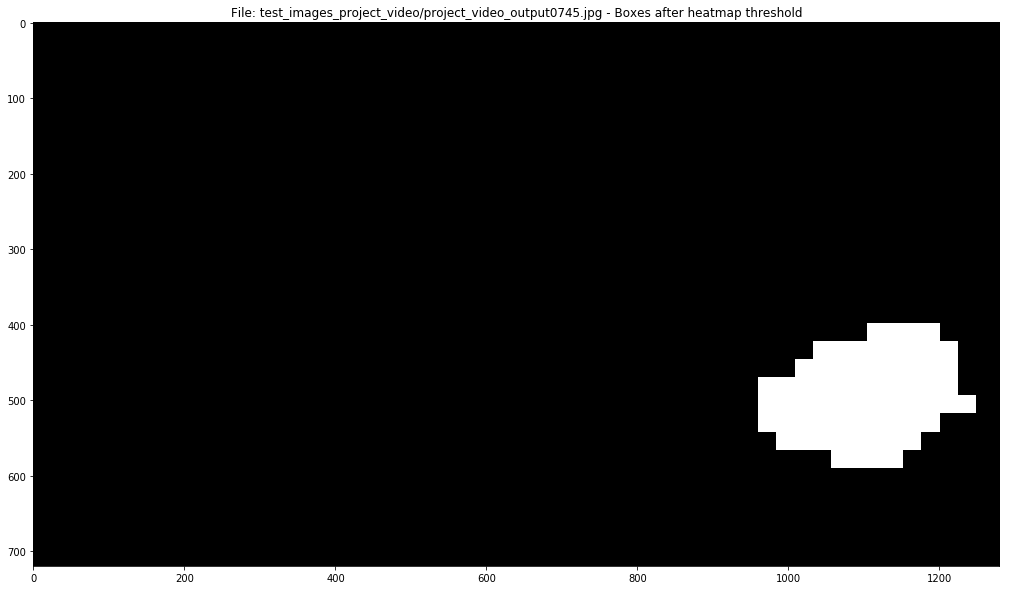

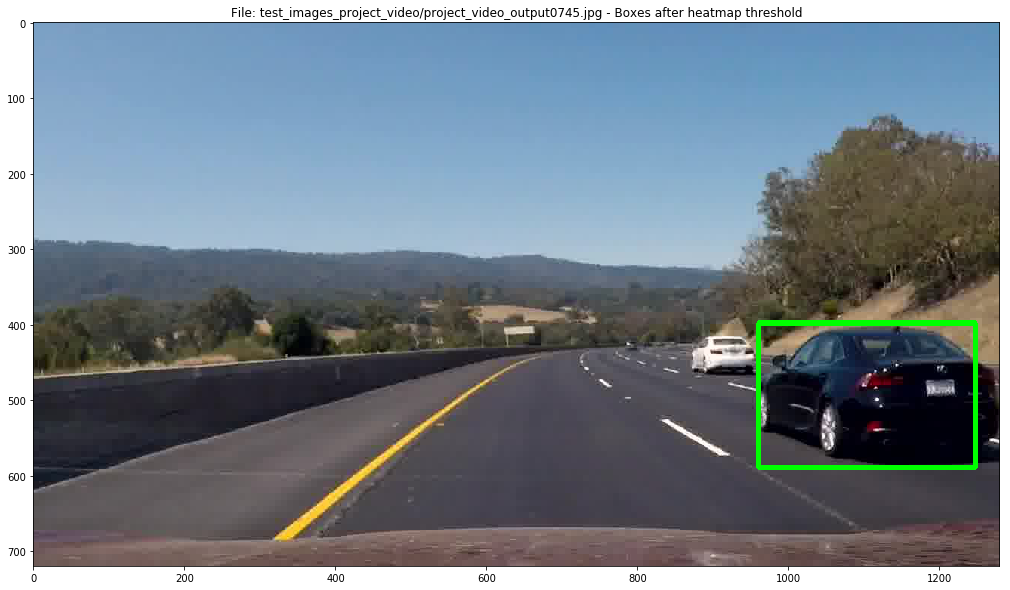

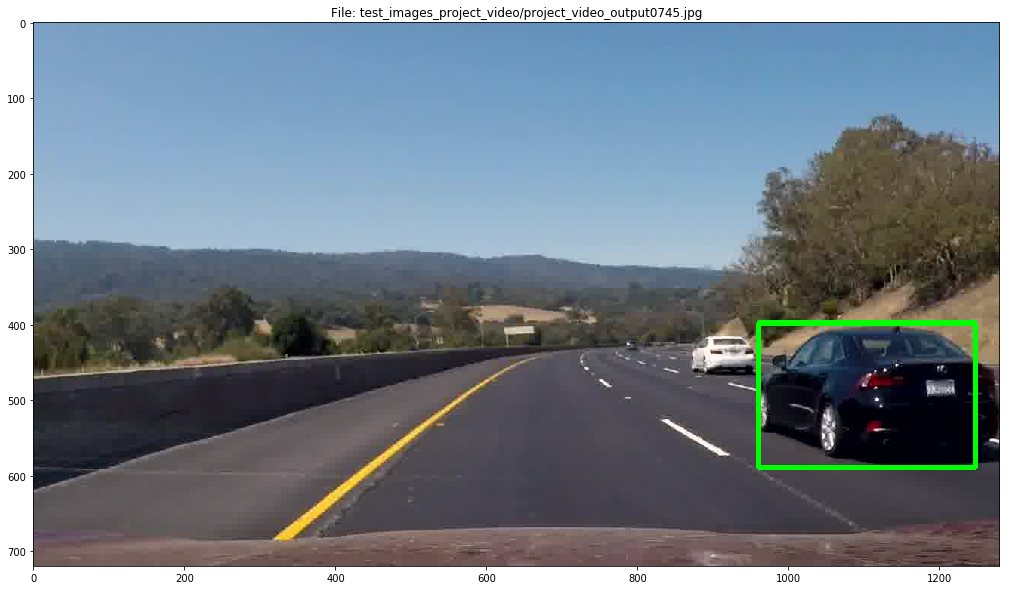

 50%|█████     | 5/10 [00:19<00:19,  3.96s/it]

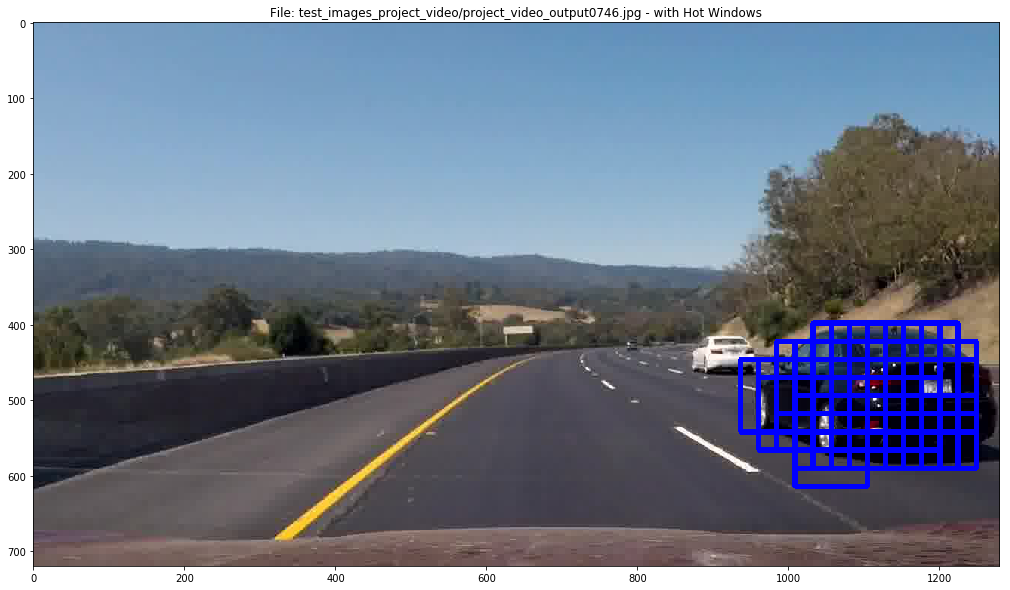

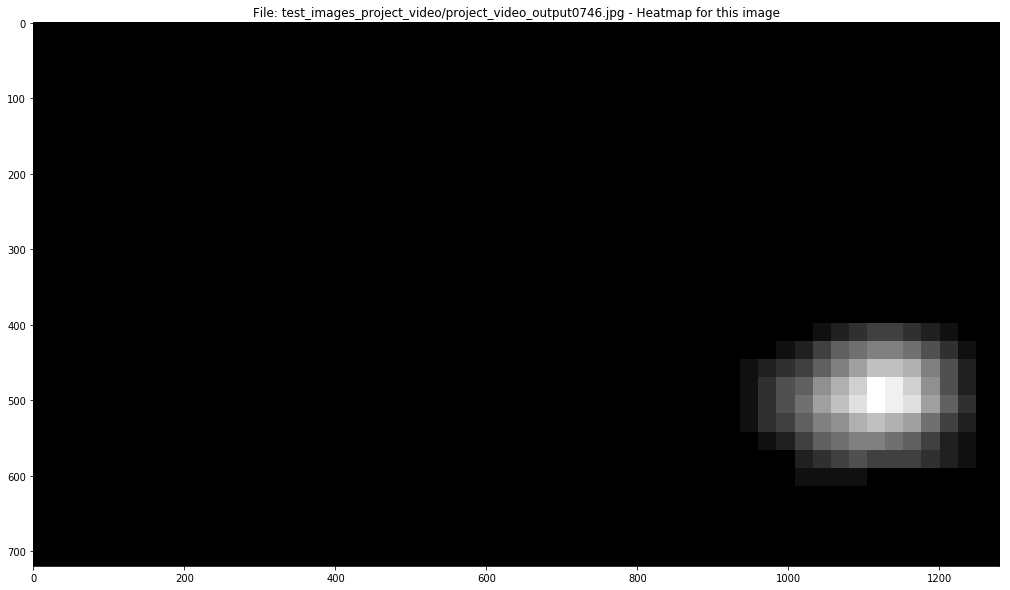

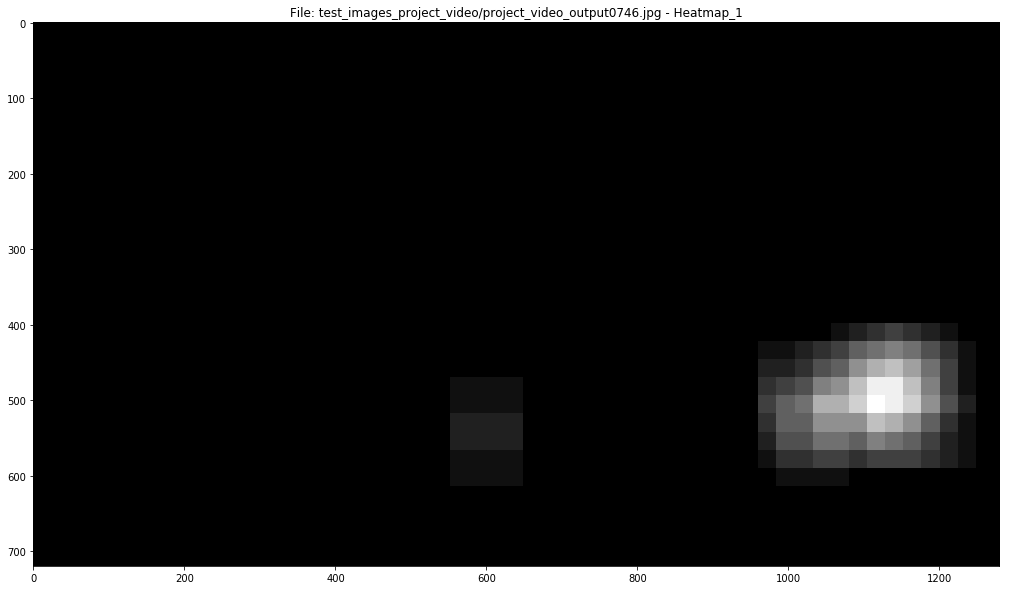

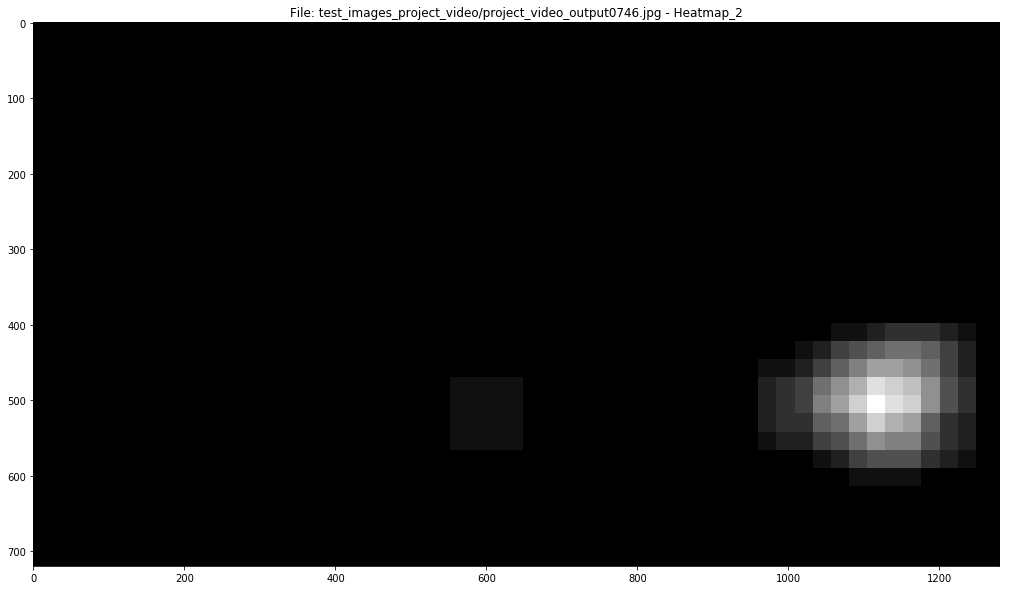

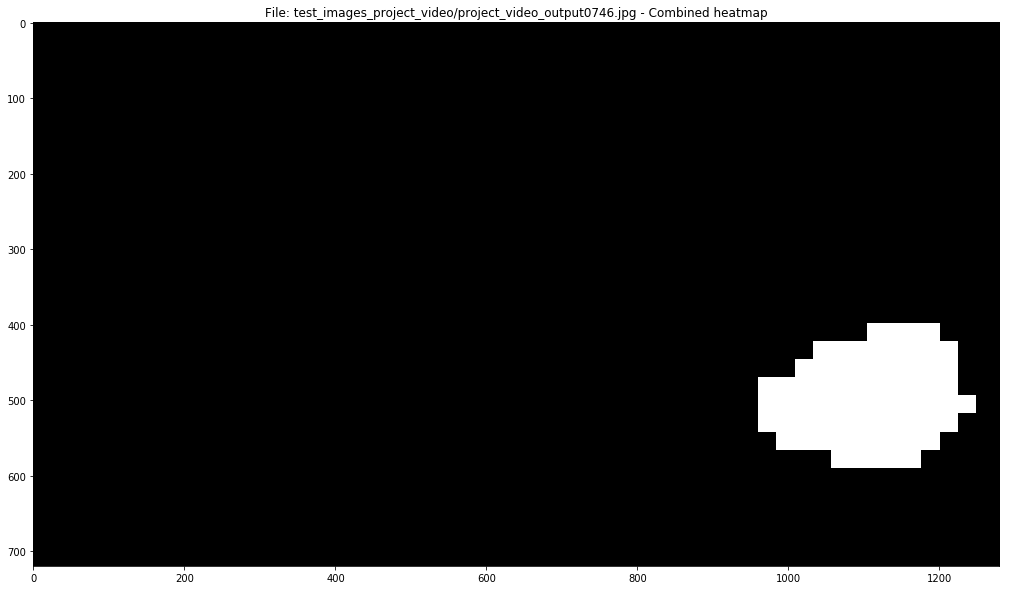

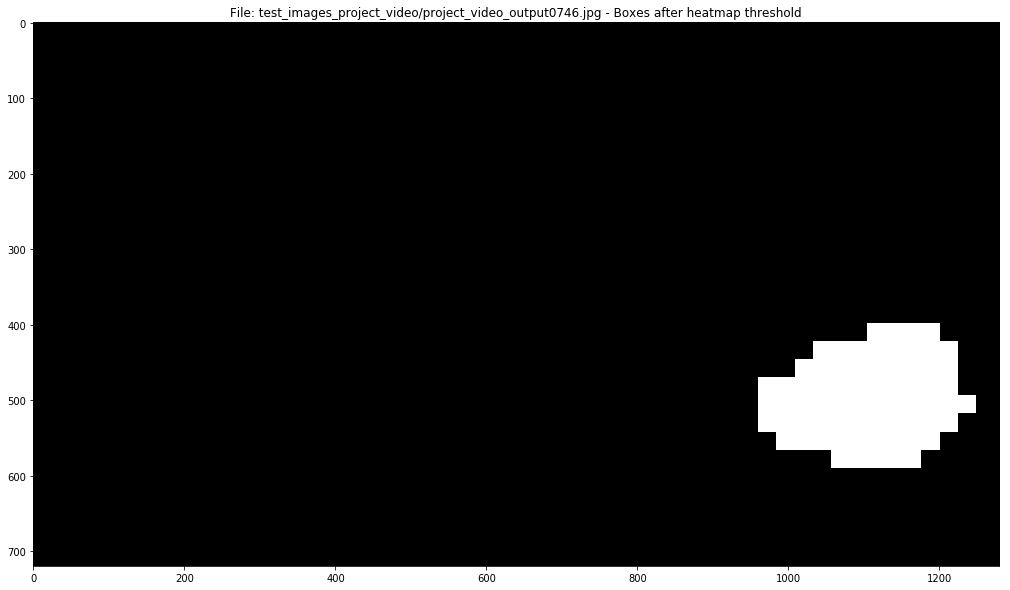

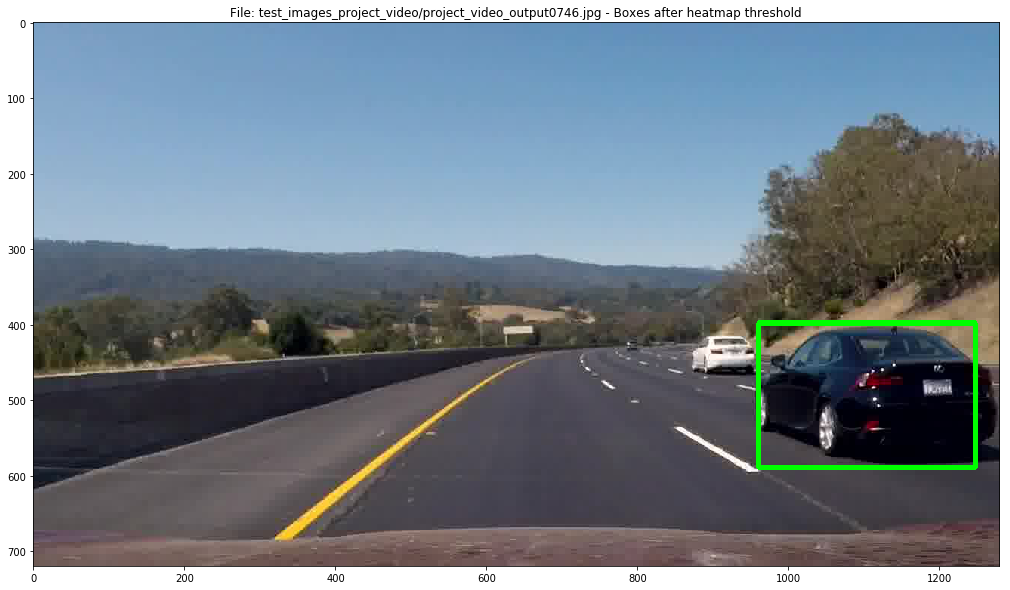

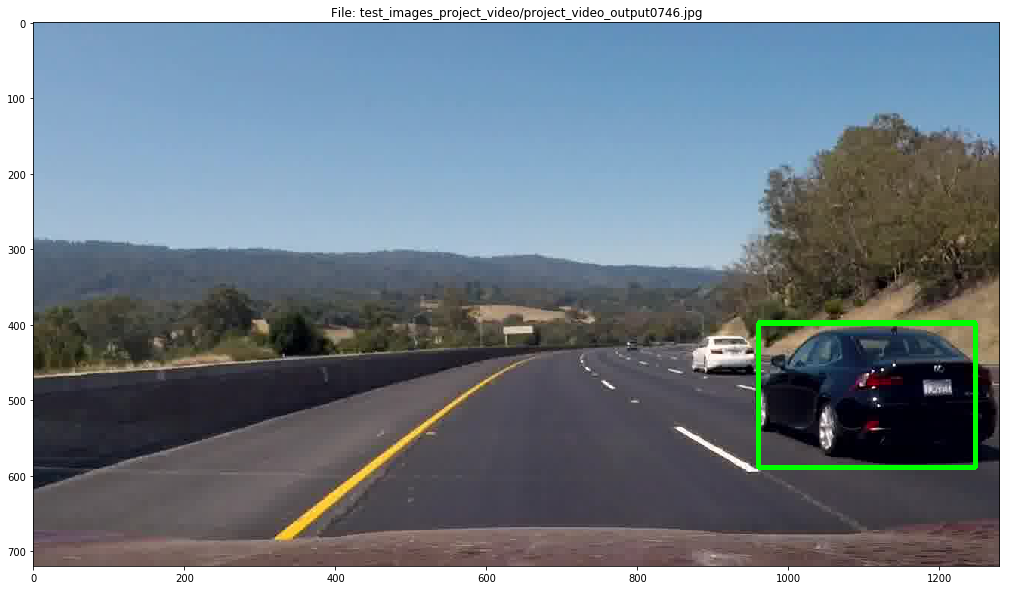

 60%|██████    | 6/10 [00:23<00:15,  3.91s/it]

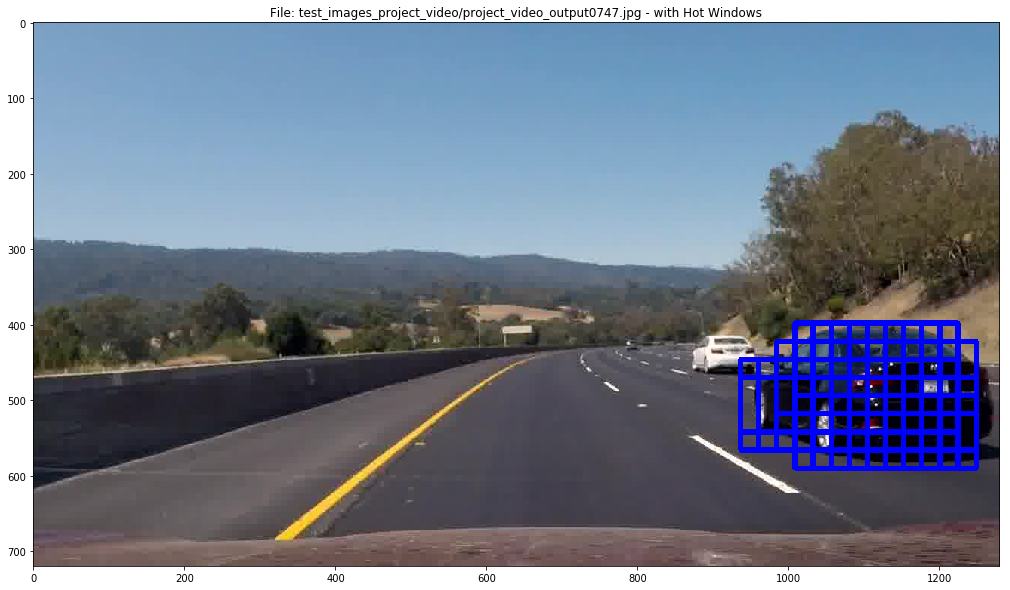

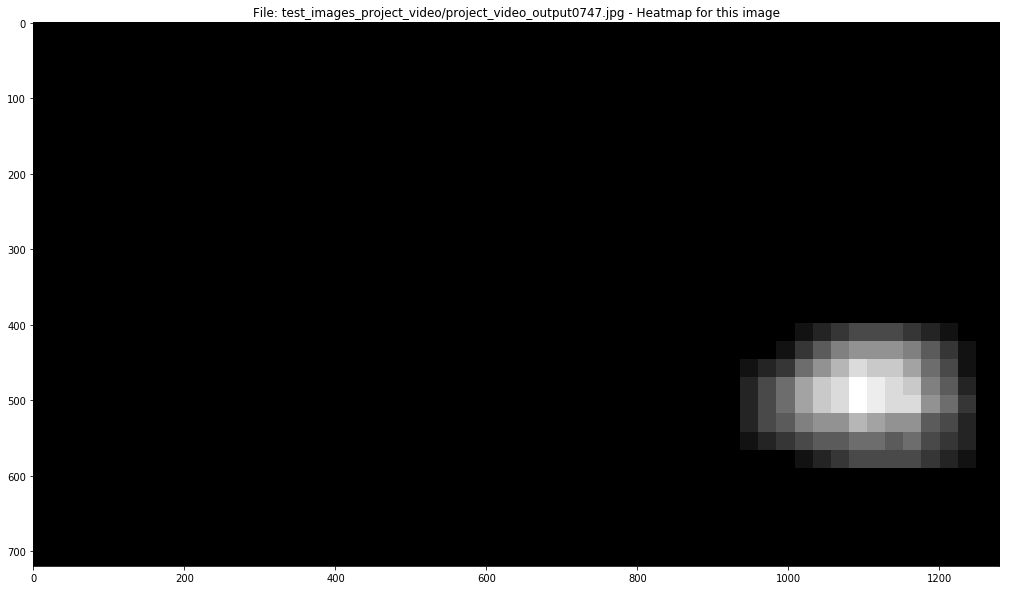

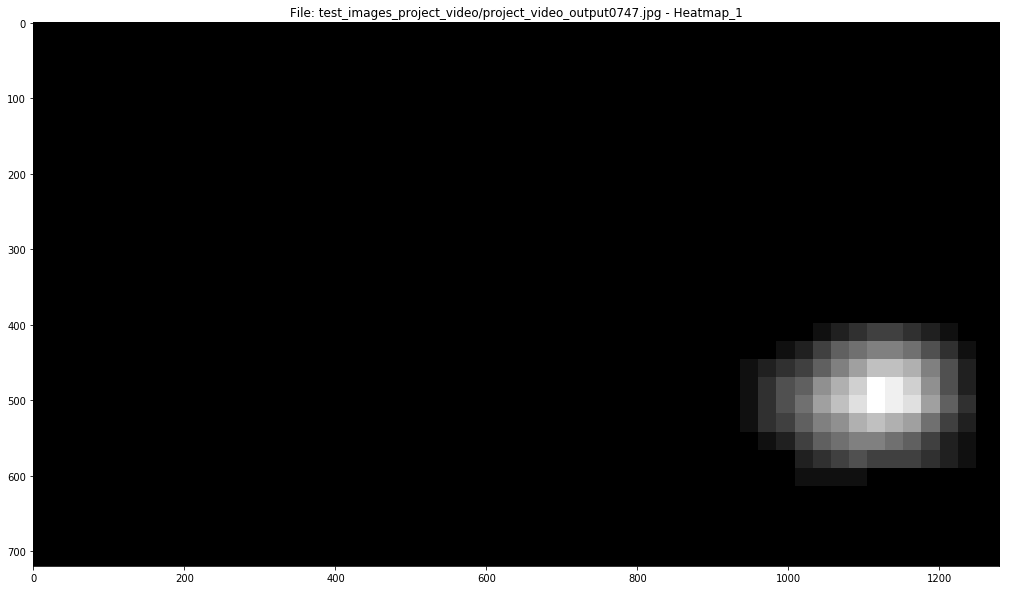

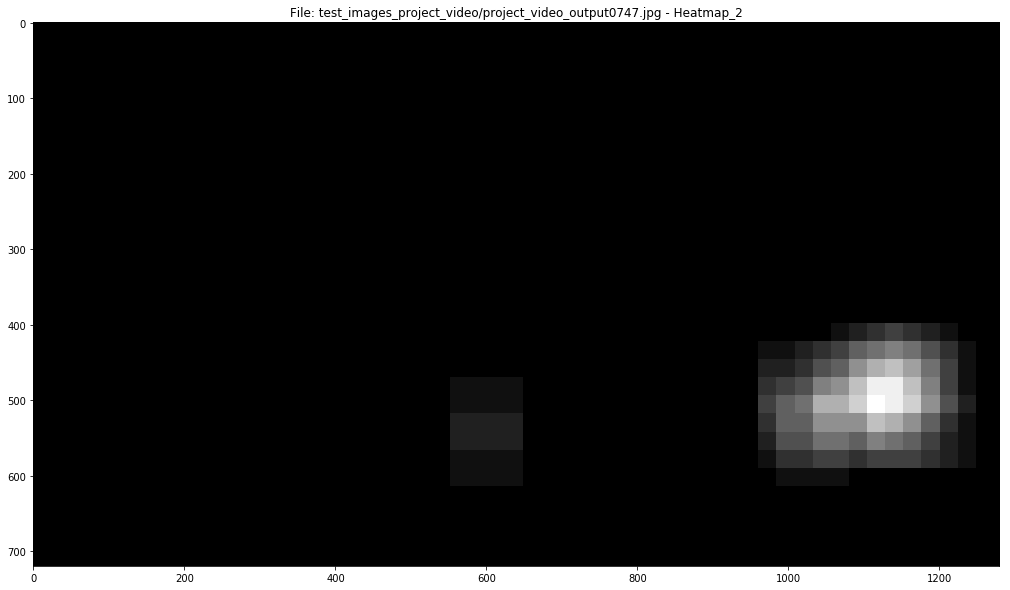

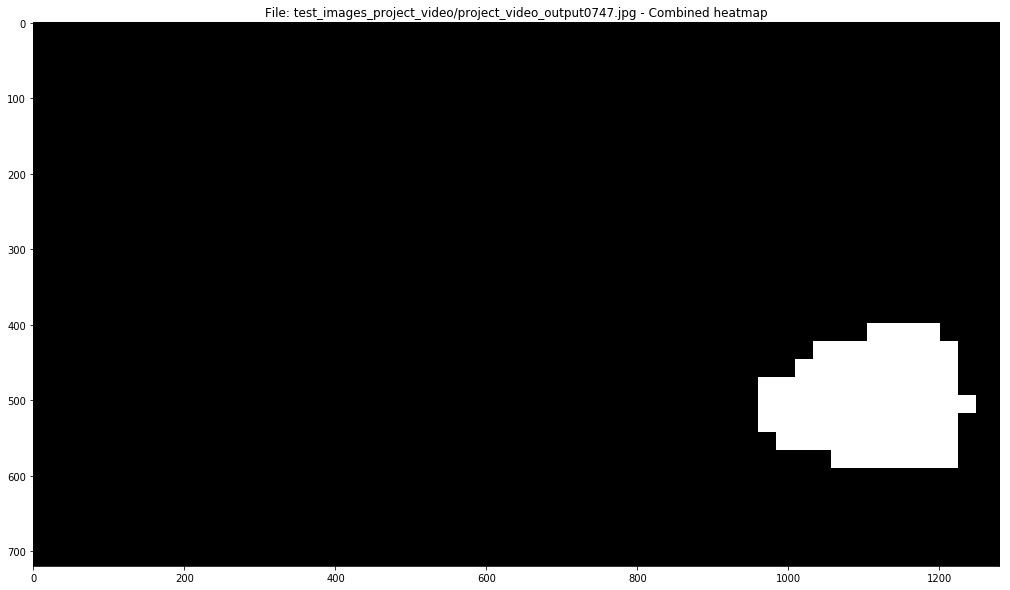

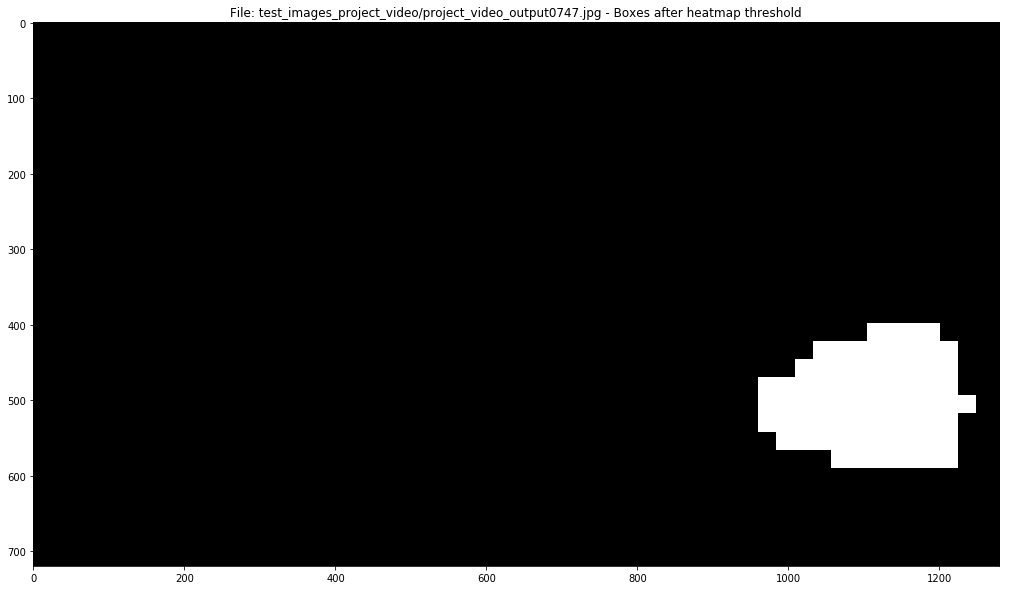

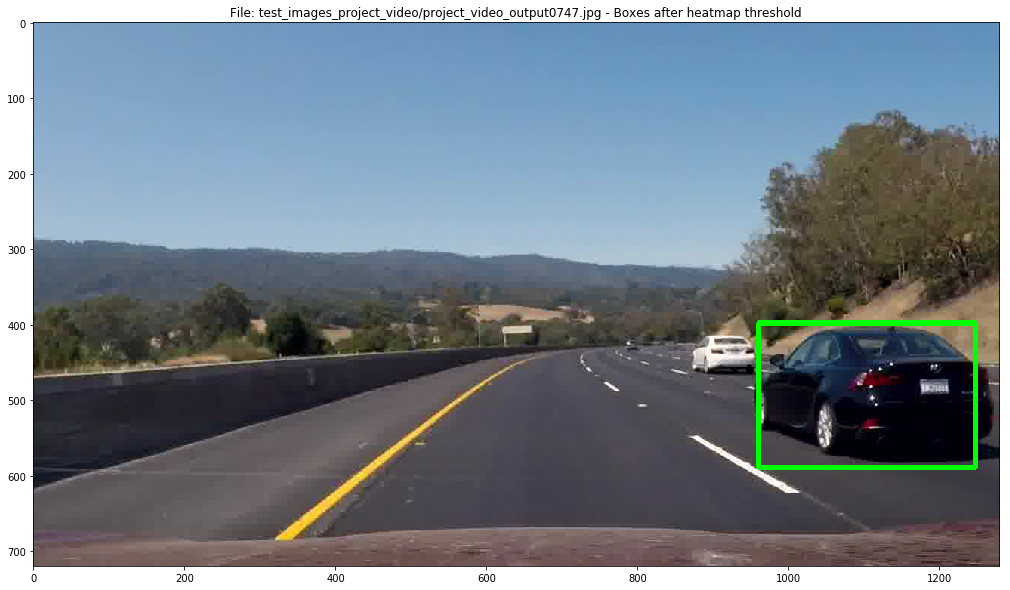

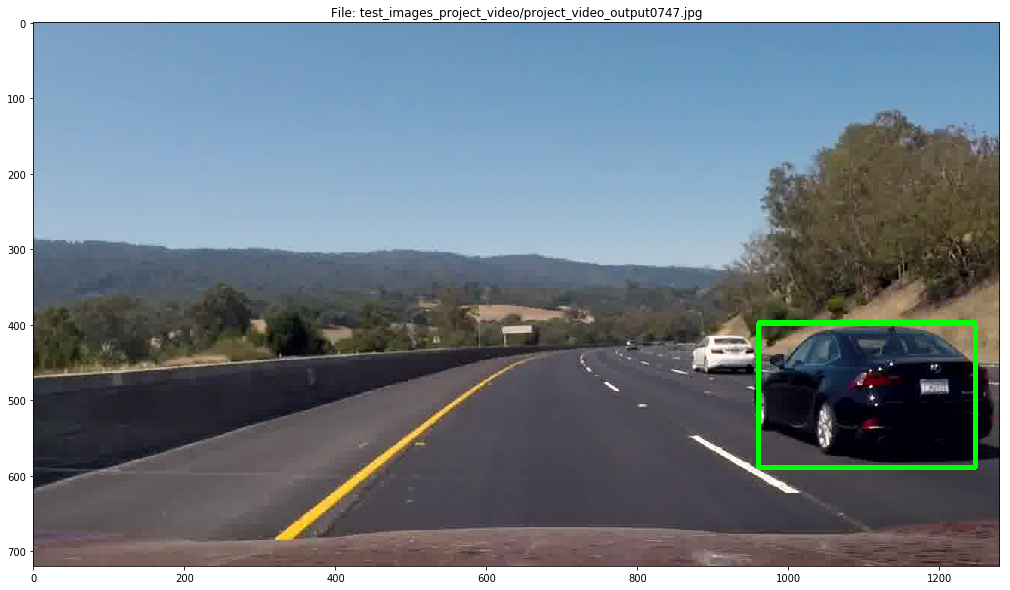

 70%|███████   | 7/10 [00:27<00:11,  3.87s/it]

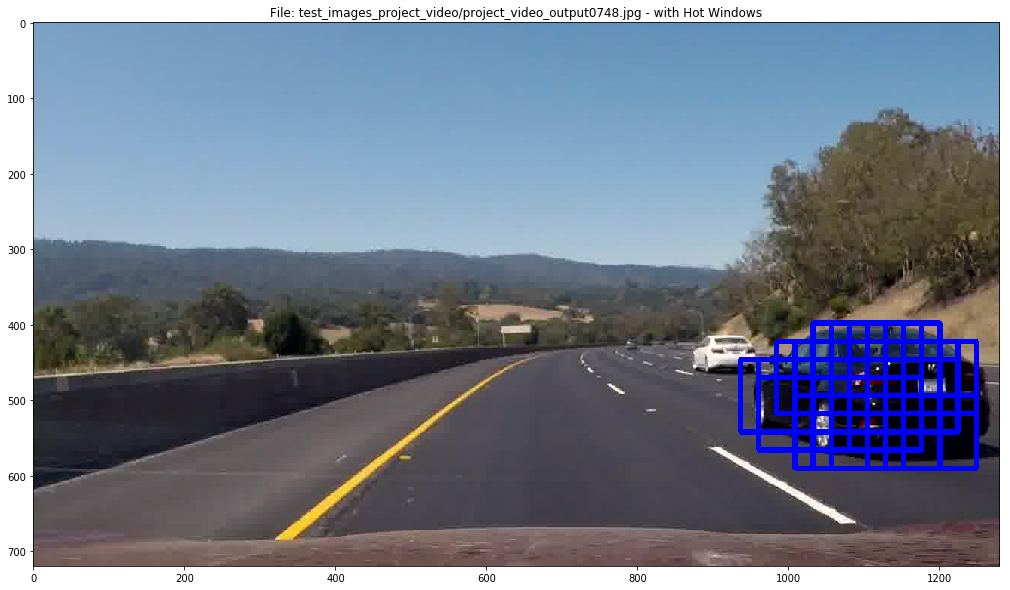

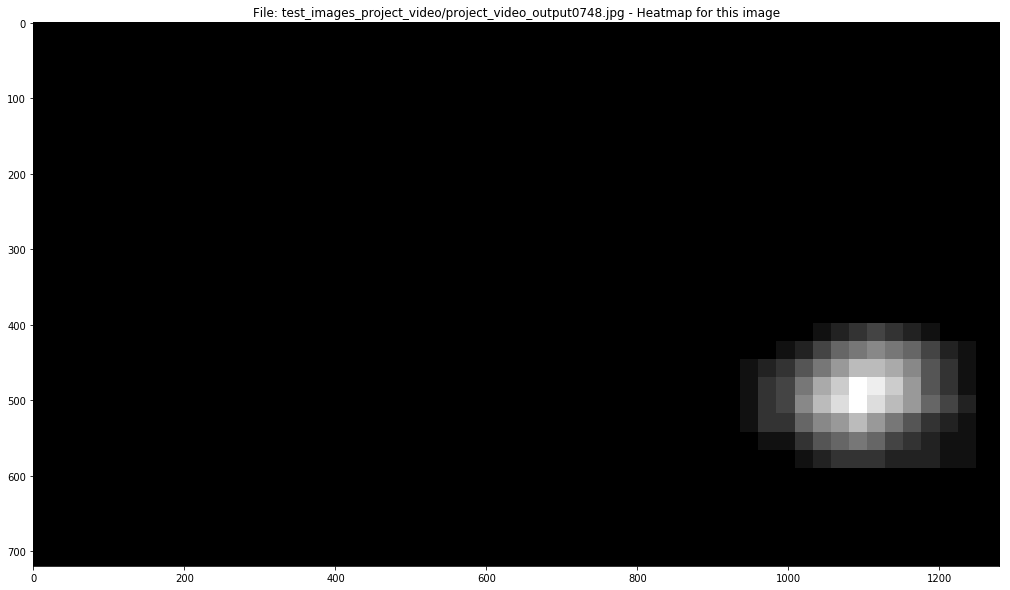

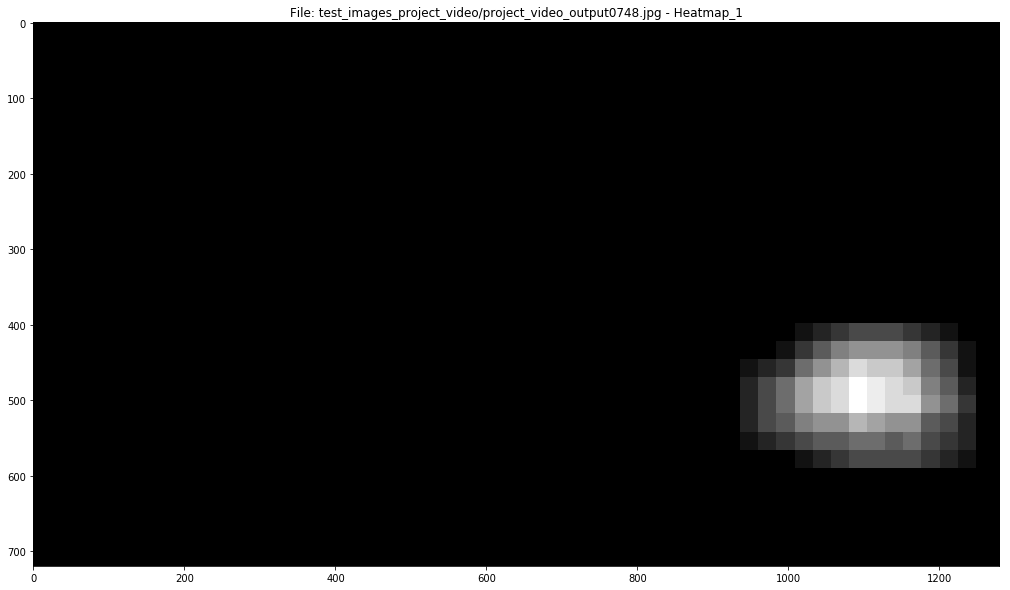

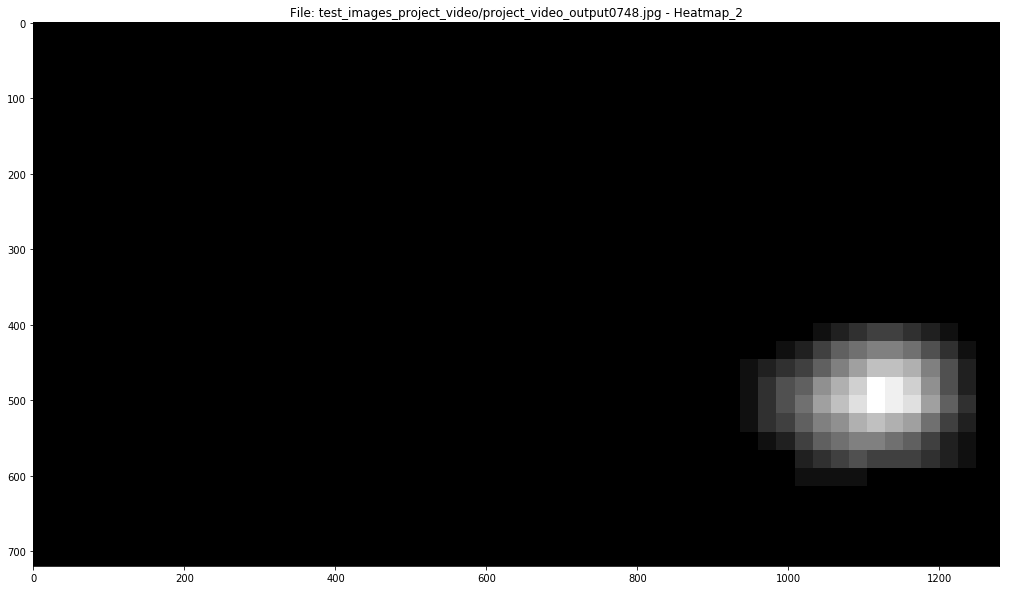

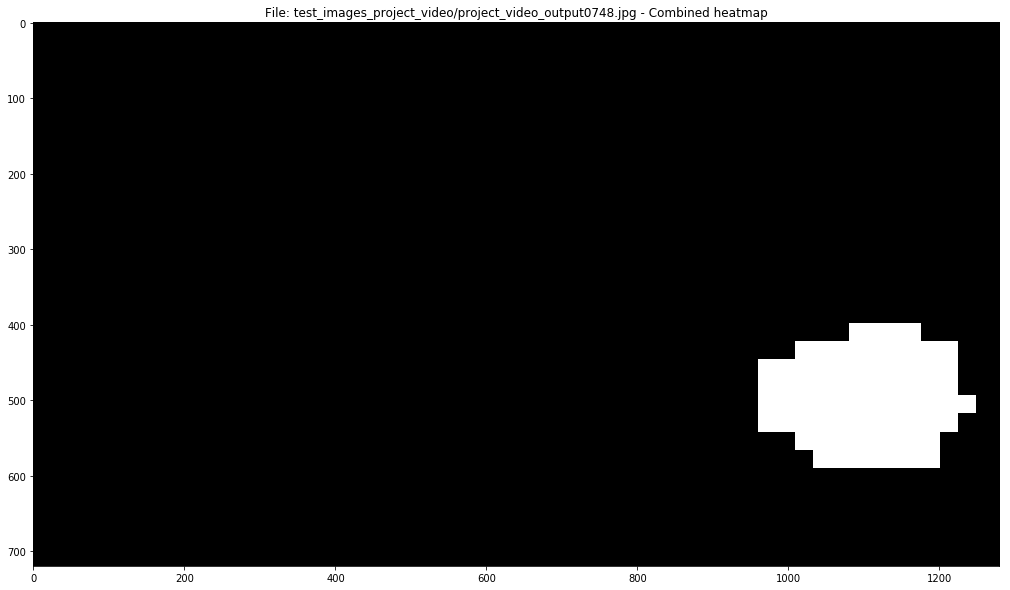

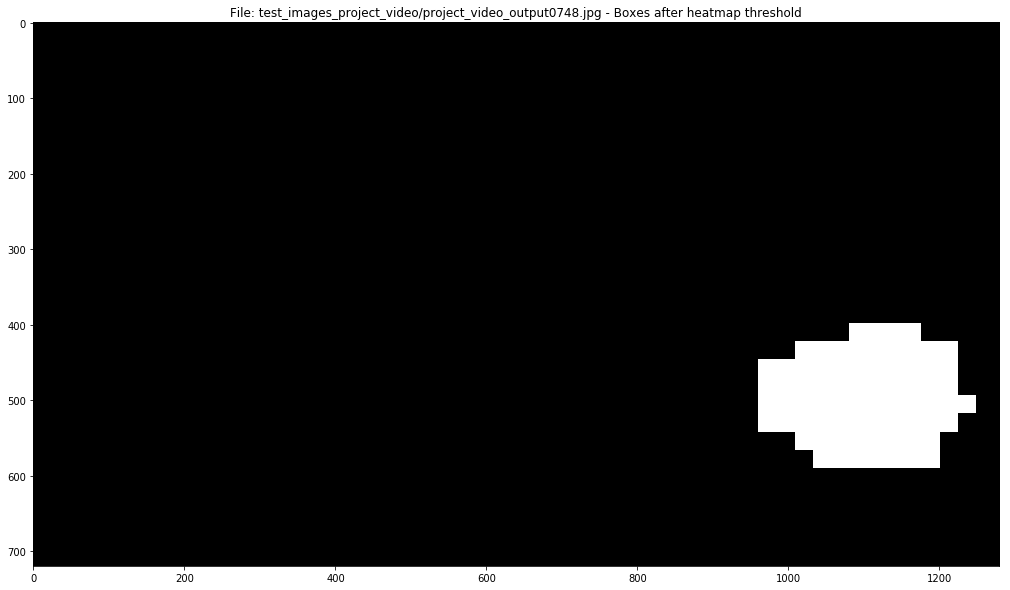

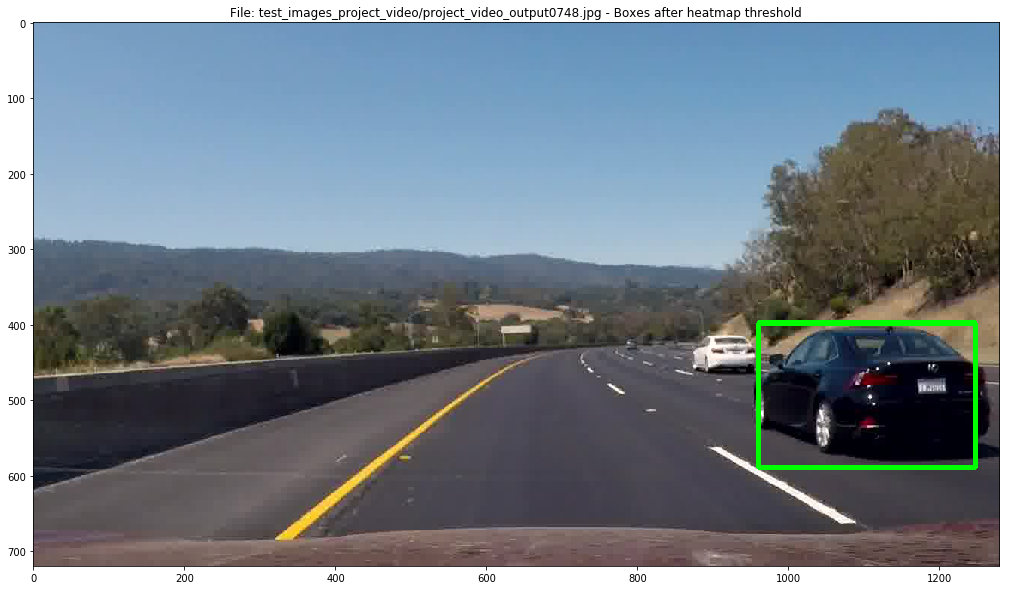

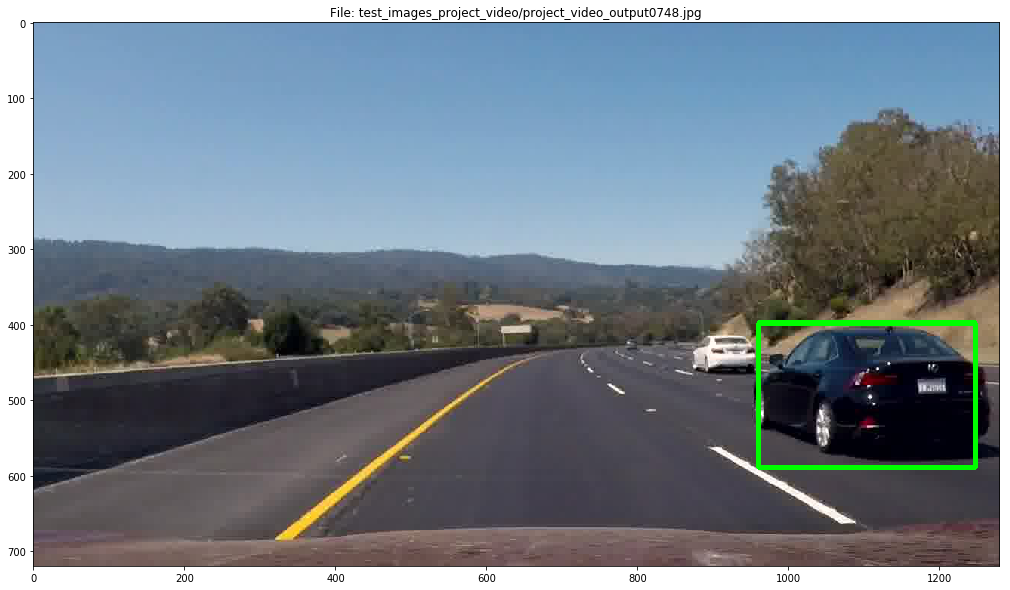

 80%|████████  | 8/10 [00:31<00:07,  3.99s/it]

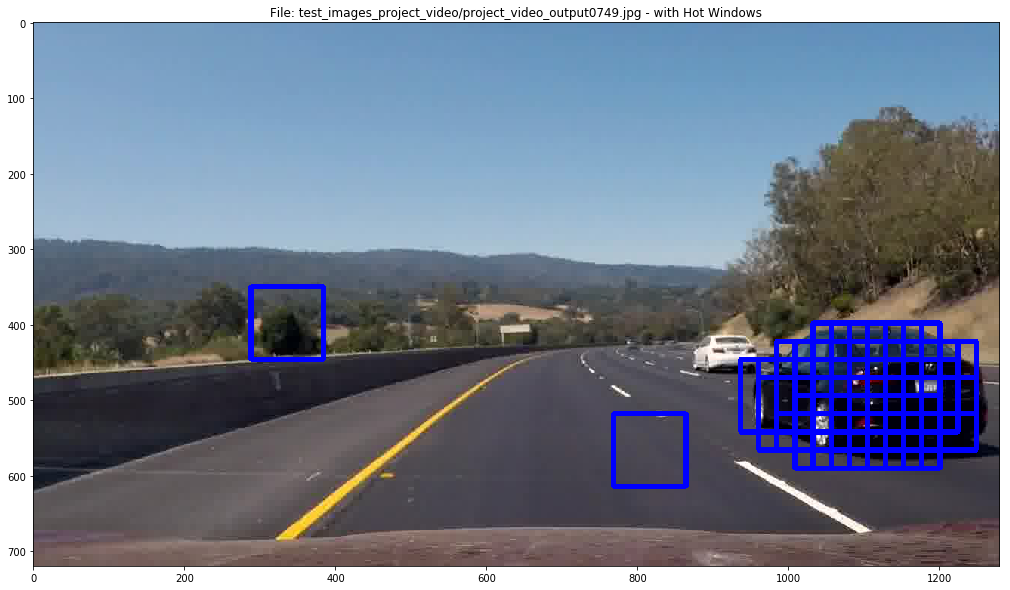

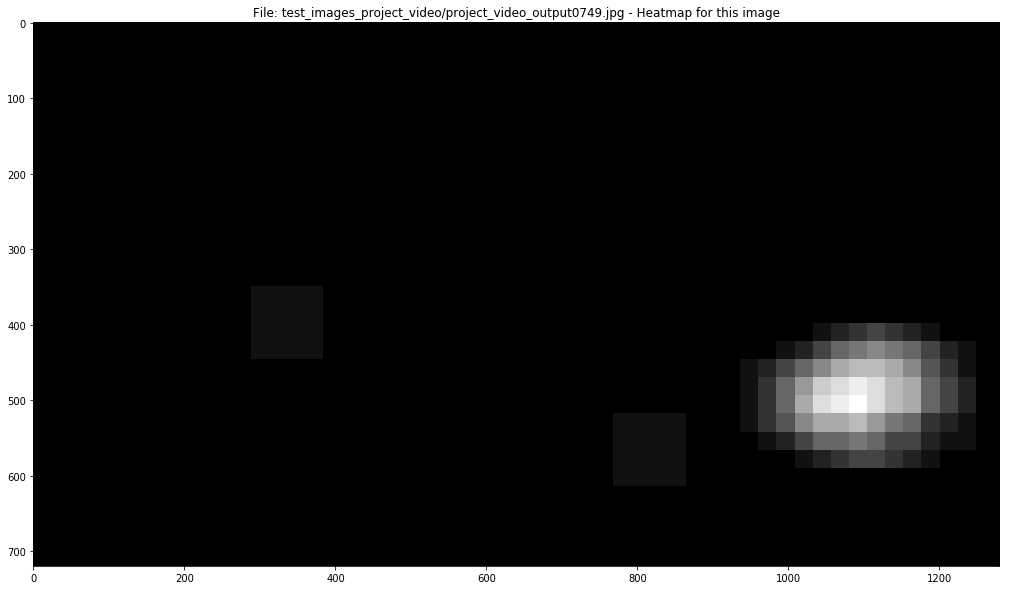

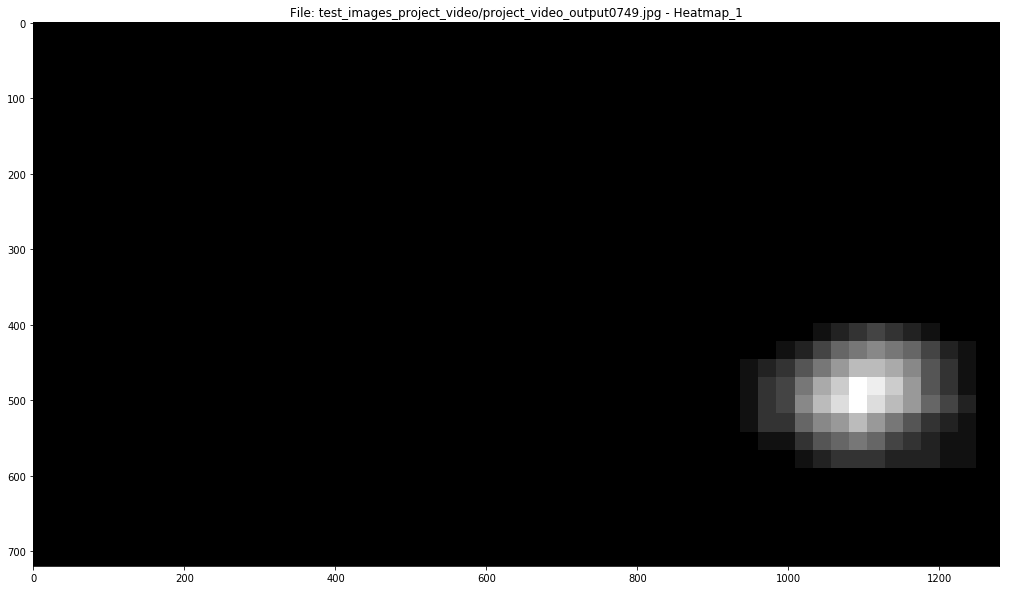

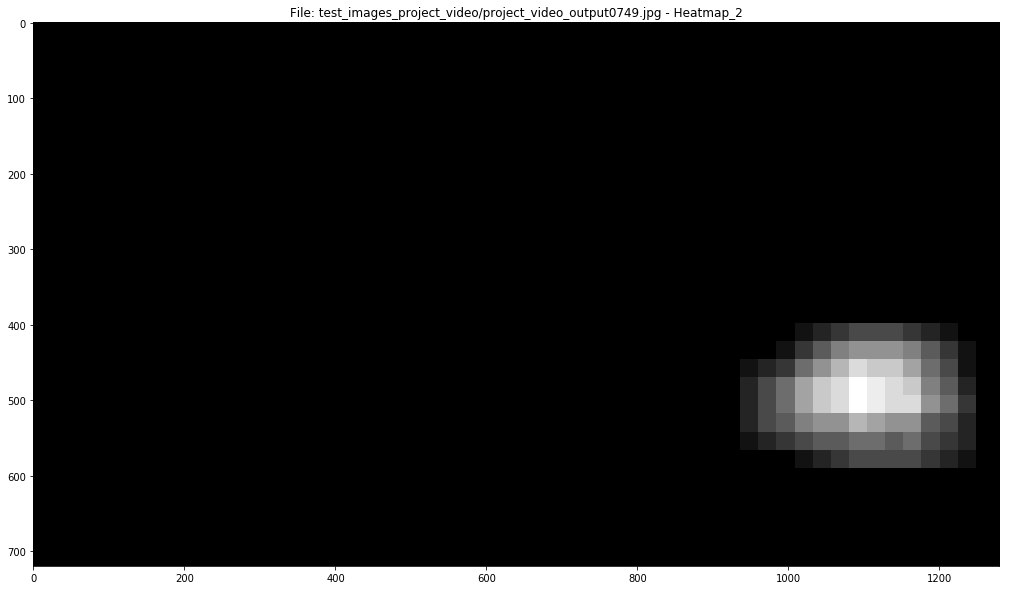

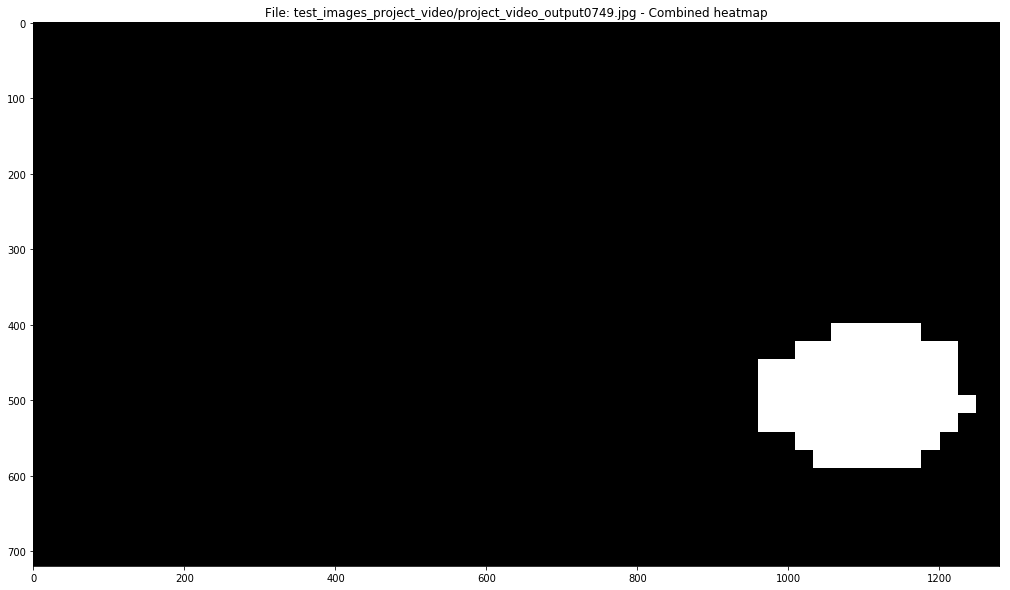

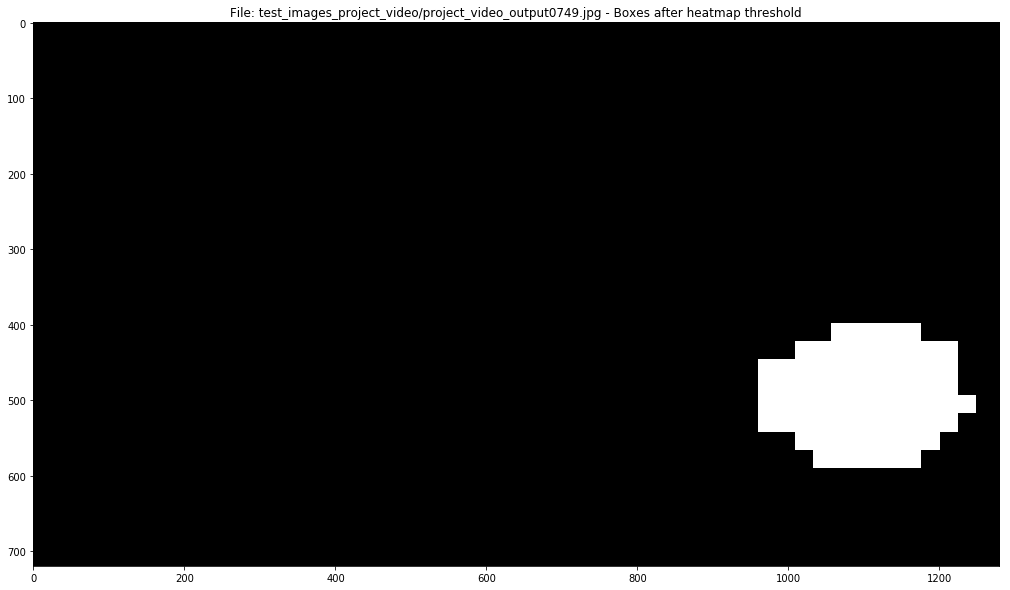

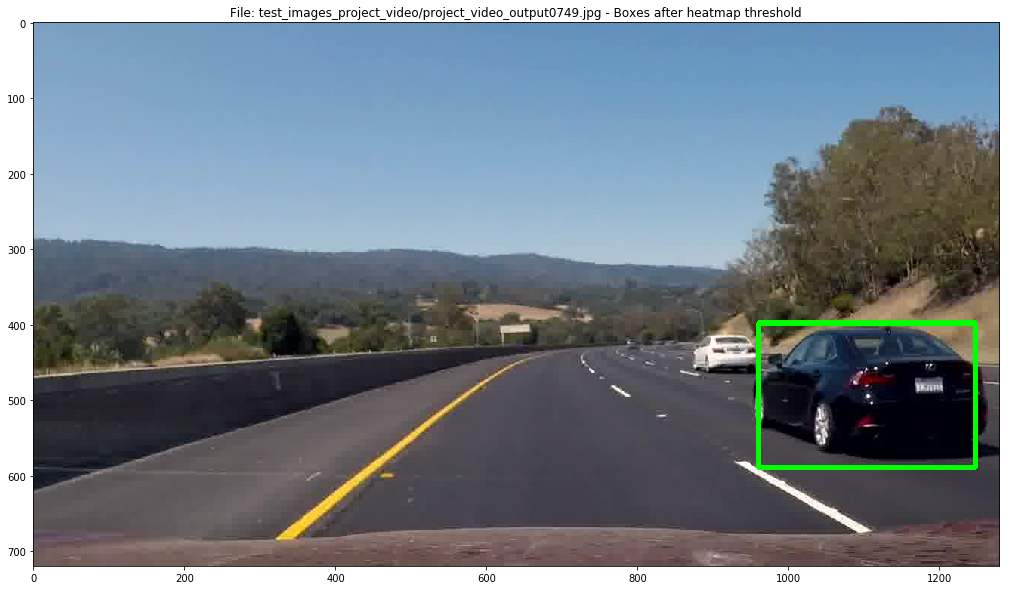

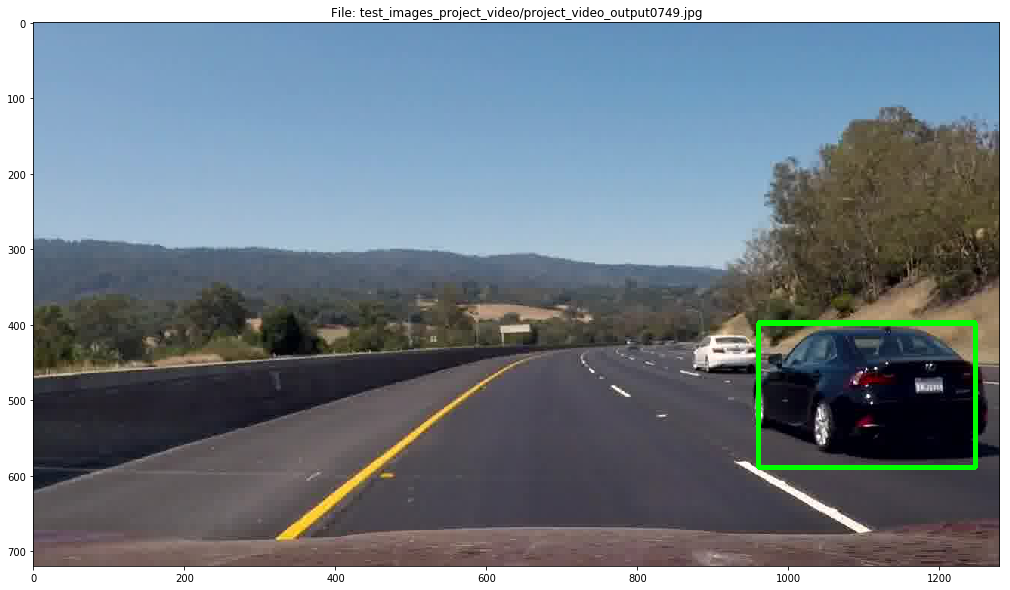

 90%|█████████ | 9/10 [00:35<00:04,  4.11s/it]

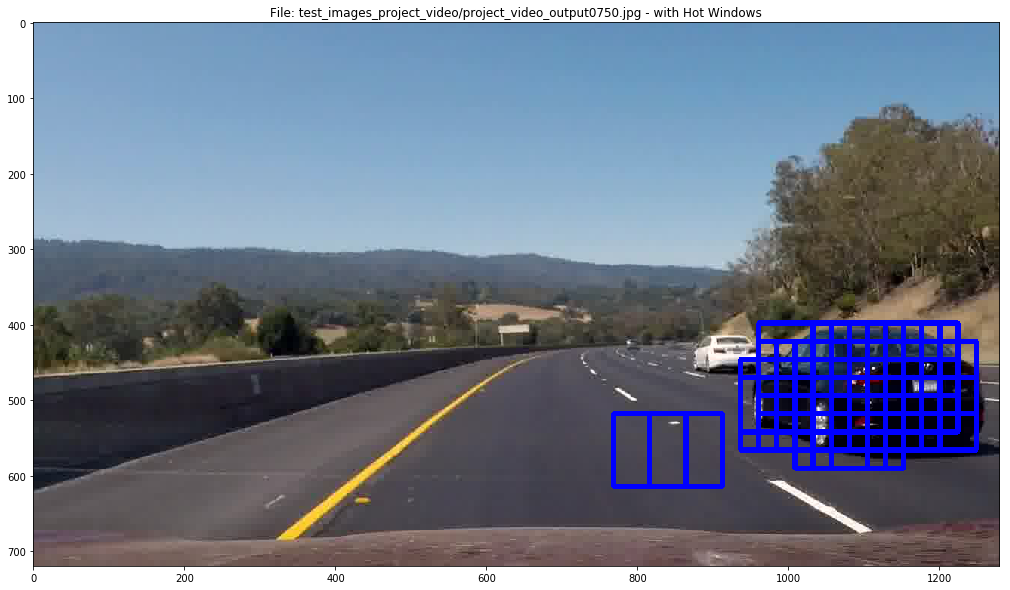

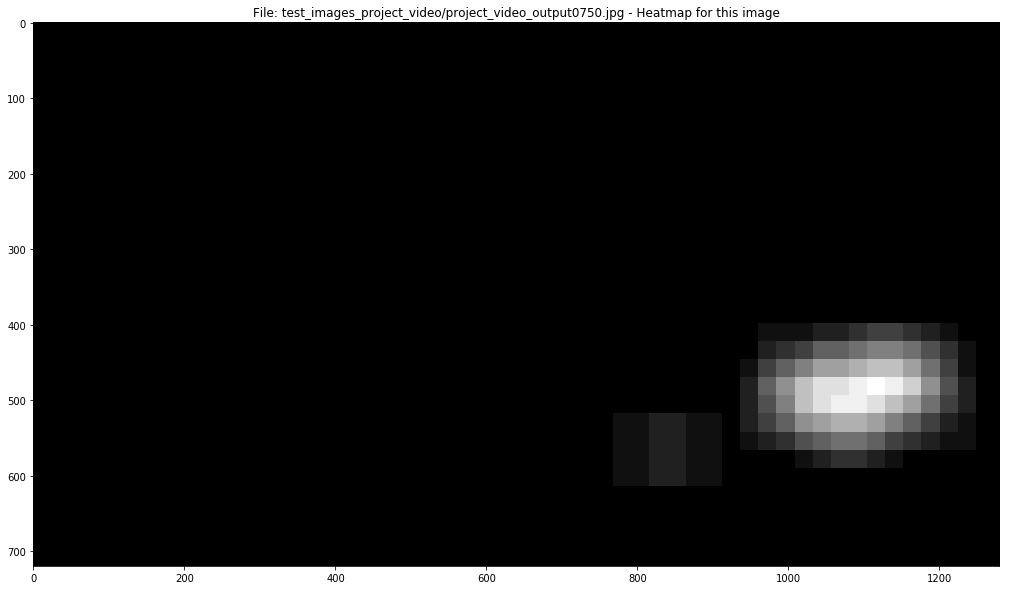

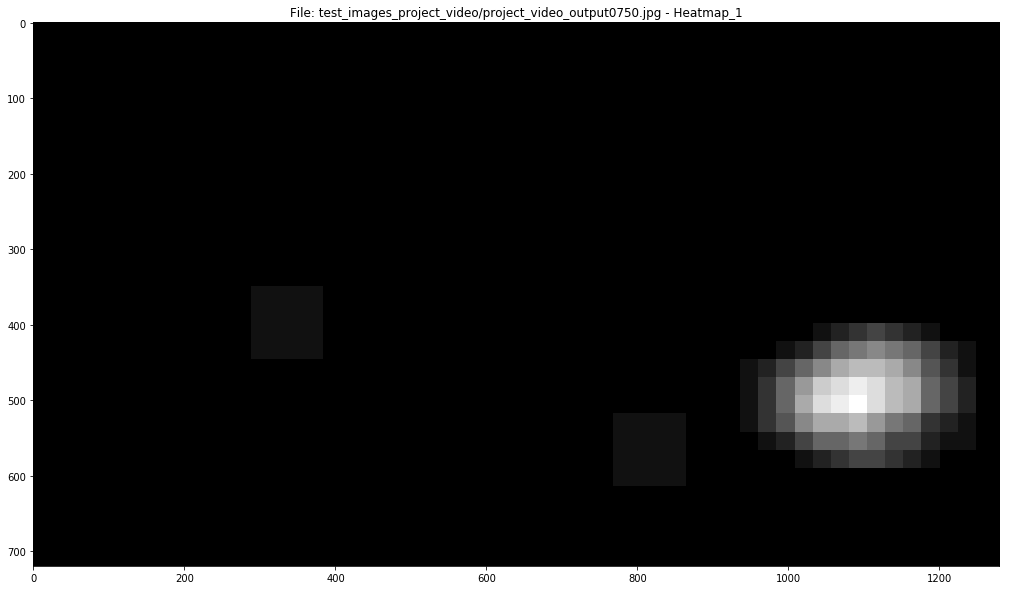

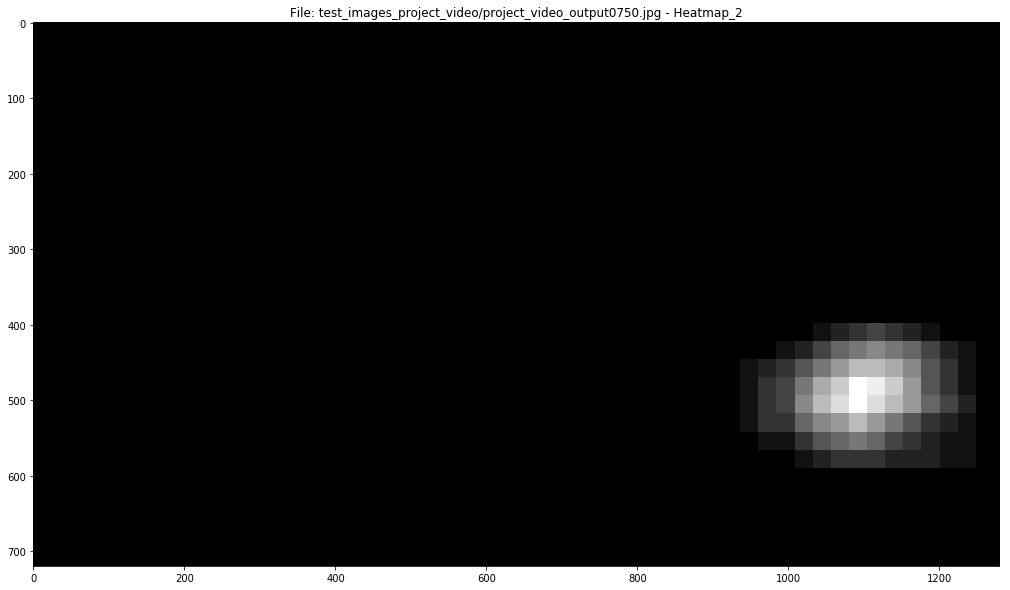

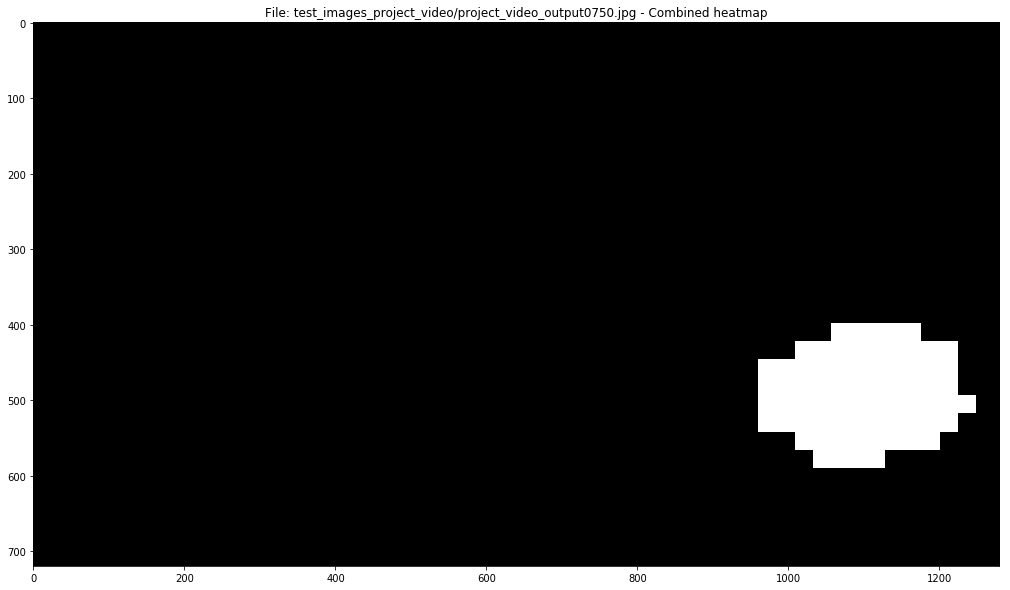

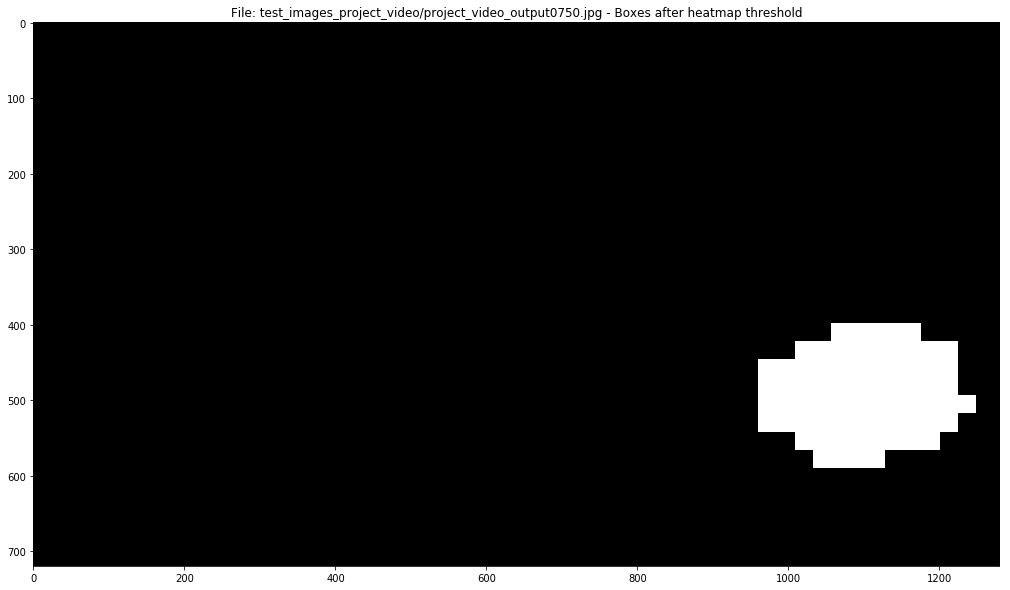

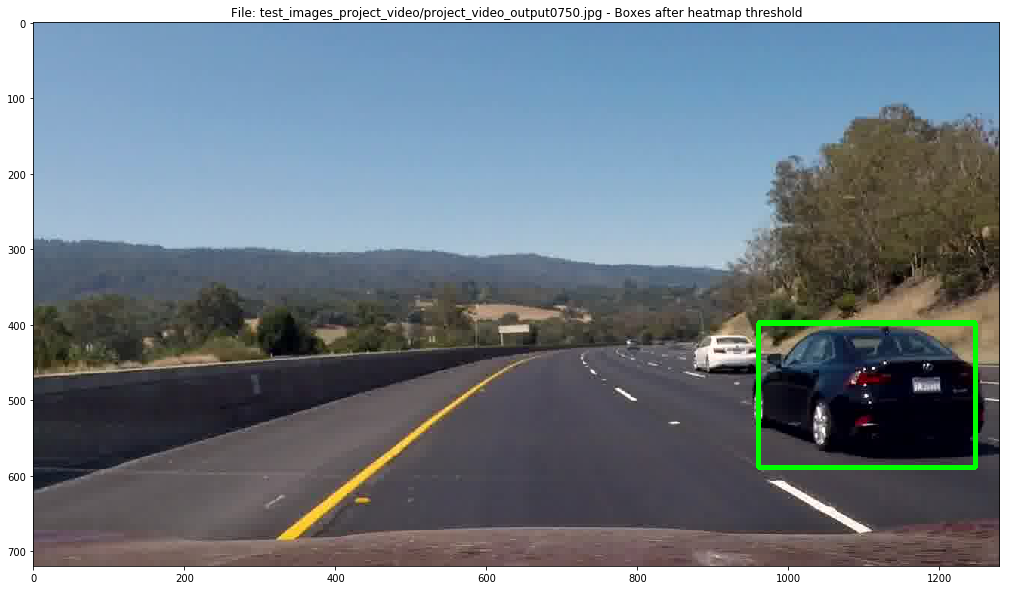

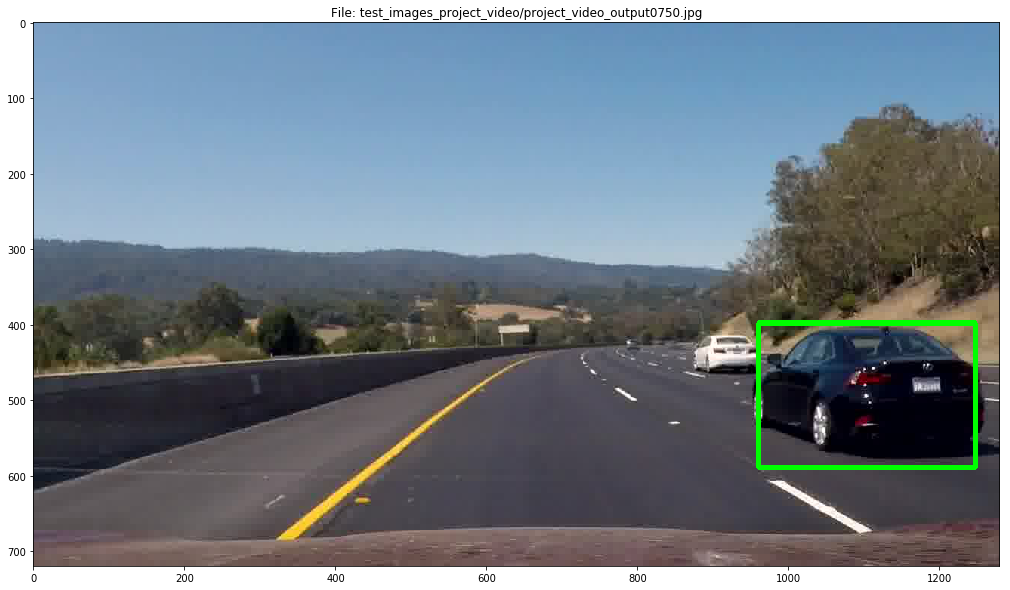

100%|██████████| 10/10 [00:40<00:00,  4.28s/it]


In [12]:
RUN_THIS_CELL  = True

x_start_stop = [None, None]  # Min and max in x to search in slide_window()
y_start_stop = [ 350,  695]  # Min and max in y to search in slide_window()

HEAT_THRESHOLD = 1
N_HOT_WINDOWS  = 4     # number of images for which we save hot_windows, for heatmap filtering

hotWindows = HotWindows()

frame            = 0

# for debugging only:
show_all         = True
show_final       = True
verbose          = False
files_debug_true = None

test_video       = 1     # [0=test_images, 1=extracted project_video images]

if RUN_THIS_CELL:
    print('Testing the lane finding using process_image function')
    #----------------------------------------------------------
   
    #----------------------------------------------------------            

    #======================================================
    if test_video==0:    
        # in test_images folder
        file_dir = "test_images"
        file_dir_out = "test_images_output"
        files = os.listdir(file_dir)
    
    elif test_video==1:
        # Images extracted from Project Video
        
        file_dir = "test_images_project_video"
        file_dir_out = "test_images_project_video_output"
        files = os.listdir(file_dir)
        
    #
    # to start in later frame:files = files[740:]
    #files = files[140:] # white car coming into view
    #frame = 140
    #files = files[200:] # white car into view
    #frame = 200    
    files = files[740:750] # black car coming into view
    frame = 740
    
    for file in tqdm(files):
    
        file_in = file_dir+"/"+file
        file_out= file_dir_out+"/"+file

        image = mpimg.imread(file_in)
        
        final_image = process_image(image, file_in)
        
        plt.imsave(file_out,final_image)
